### 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

### 1. Preliminary View of Data

In [2]:
# Preliminary view of data
df = pd.read_csv('/Users/muhammadsulaimanmuhammadrizam/Documents/VSCode Files/Datasets/covtype.csv')
col_names = df.columns
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# Checking for null values in dataset
print(df.isnull().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [4]:
# Extract continuous features
cont_features = df[col_names[0:10]].copy()
cont_features.rename(columns={'Horizontal_Distance_To_Hydrology':'H_Dist_To_Water',
                              'Vertical_Distance_To_Hydrology':'V_Dist_To_Water',
                              'Horizontal_Distance_To_Roadways':'H_Dist_To_Roads',
                              'Horizontal_Distance_To_Fire_Points':'H_Dist_To_Fpoint'}, inplace=True)
cont_colnames = cont_features.columns.to_list()

# Extract discrete features
disc_features = df[col_names[10:]].copy()
disc_colnames = disc_features.columns.to_list()

# Extract wilderness areas & soil types as separate dataframes
keyword1 = 'Wilderness_Area'; keyword2 = 'Soil_Type'
WA_columns = [col for col in df.columns if keyword1 in col]; ST_columns = [col for col in df.columns if keyword2 in col]
df_WA = df[WA_columns]
df_soil = df[ST_columns]

# Identify number of labels in dataset
df['Cover_Type'].value_counts()

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

In [5]:
# Add new features for feature engineering
cont_features['Eucld_Dist_To_Water'] = np.sqrt(df['Vertical_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Hydrology']**2)
cont_colnames.append('Eucld_Dist_To_Water')

cont_features['Mean_Hillshade'] = (df['Hillshade_9am']+df['Hillshade_Noon']+df['Hillshade_3pm'])/3
cont_colnames.append('Mean_Hillshade')

In [6]:
# Summary statistics for continuous features
cont_features.describe().drop('count',axis=0)

,Elevation,Aspect,Slope,H_Dist_To_Water,V_Dist_To_Water,H_Dist_To_Roads,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,H_Dist_To_Fpoint,Eucld_Dist_To_Water,Mean_Hillshade
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,276.065482,192.664343
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,217.047653,14.465670
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.666667
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,108.461975,185.666667
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,229.477668,195.333333
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,393.814677,203.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1418.916840,213.666667


### 2. Graphical & Statistical Understanding

Need to rescale the continuous features according to a Normal distribution to observe which to include in for model fitting for ML.

In [7]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# Convert the continuous features from the dataset into a numpy array
cont_features = cont_features.to_numpy()

# Normalize the continuous features
conv_cont_features = std_scaler.fit_transform(cont_features)

# Convert the normalized continuous features back into a Pandas dataframe
cont_features = pd.DataFrame(conv_cont_features, columns=cont_colnames)

# Adding back 'Cover_Type' labels to normalized continuous data
cont_features['Cover_Type'] = df['Cover_Type']
cont_features.head()

,Elevation,Aspect,Slope,H_Dist_To_Water,V_Dist_To_Water,H_Dist_To_Roads,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,H_Dist_To_Fpoint,Eucld_Dist_To_Water,Mean_Hillshade,Cover_Type
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,0.142960,3.246283,-0.083233,0.530152,5
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,0.221342,3.205504,-0.294777,0.645367,5
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,-0.196691,3.126965,-0.001362,0.668410,2
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,-0.536343,3.194931,-0.031466,0.461022,2
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,0.195215,3.165479,-0.566983,0.599281,5


Plot histograms of data based on label to identify independence and distinguish normality

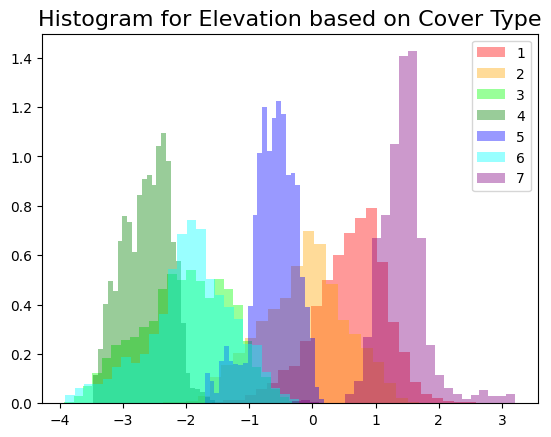

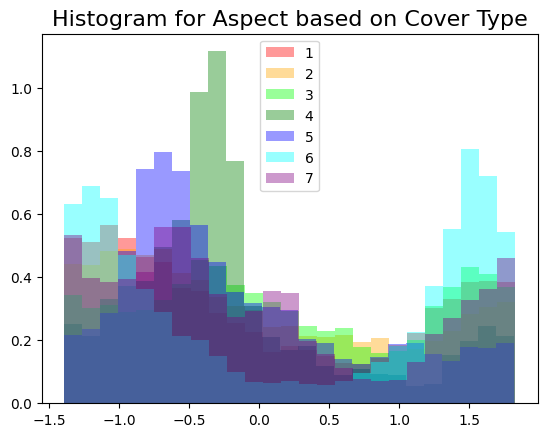

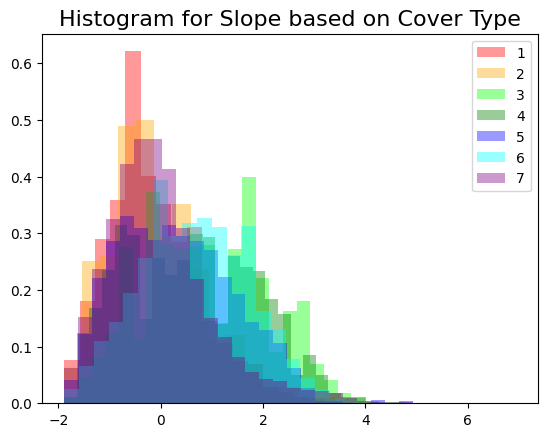

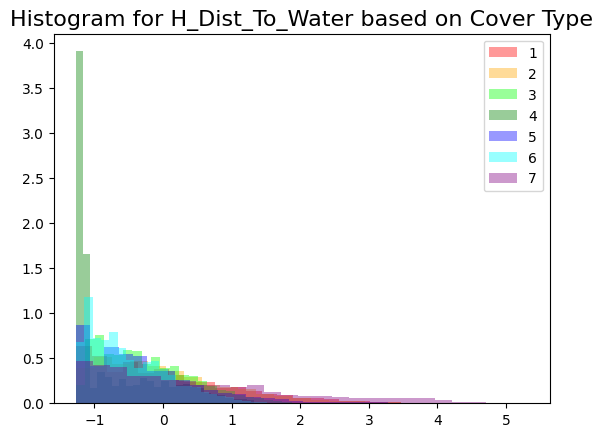

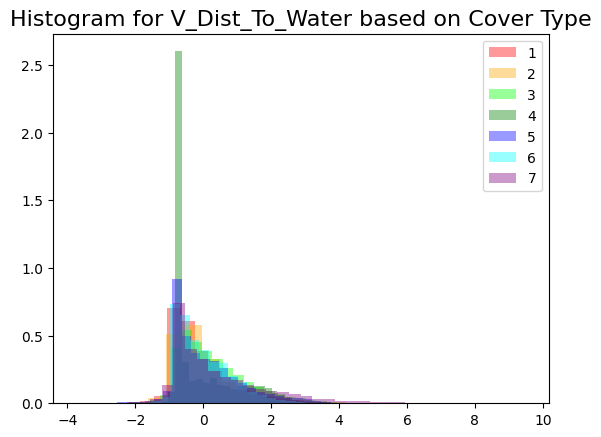

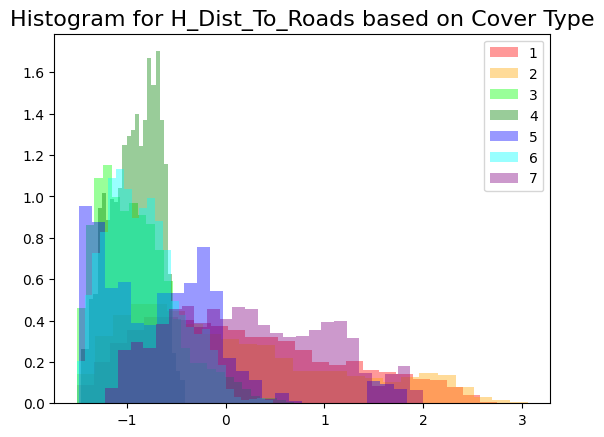

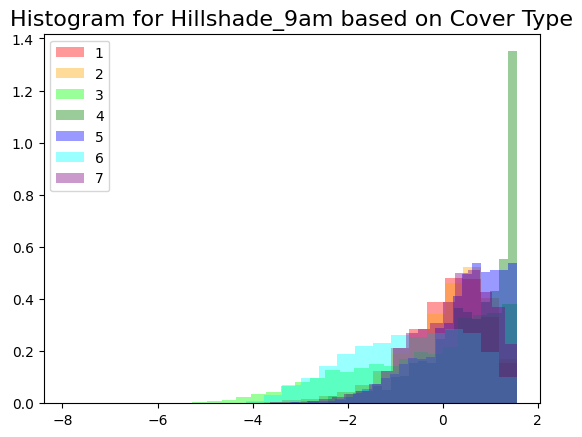

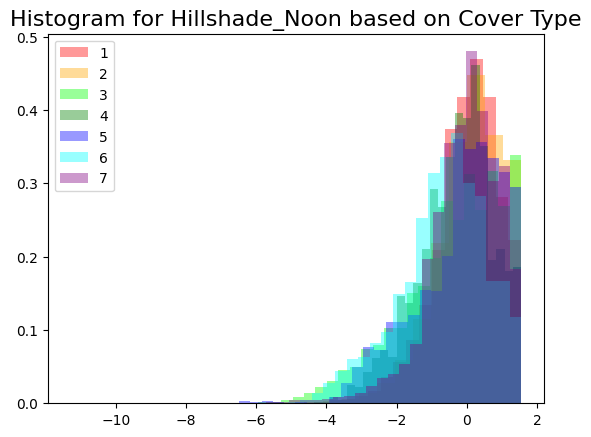

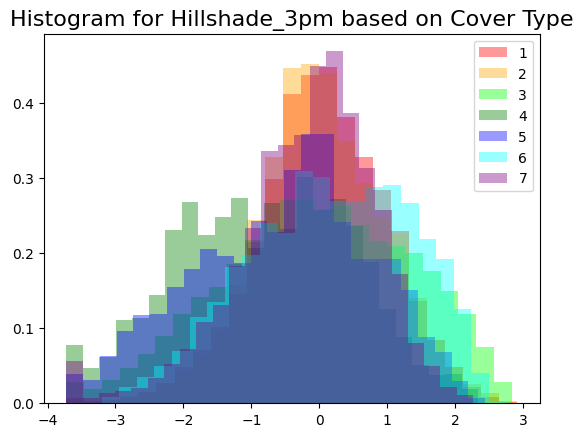

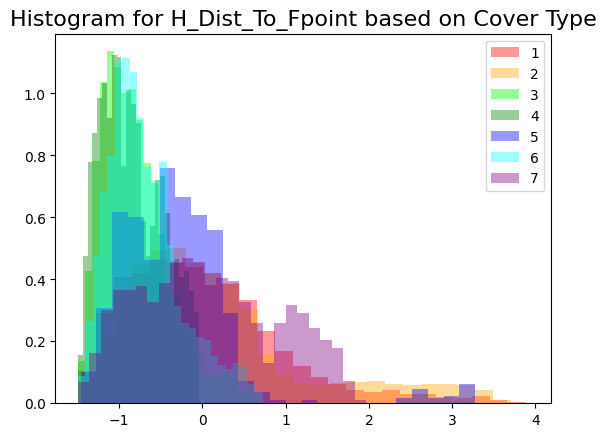

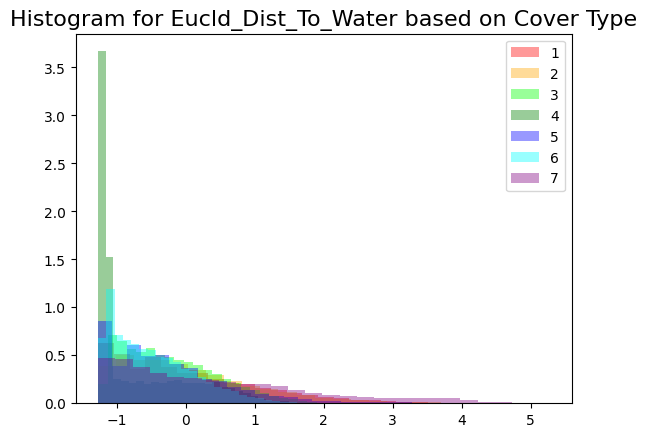

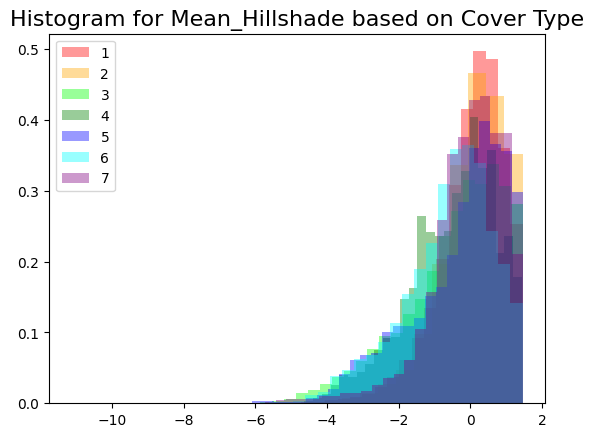

In [8]:
# Define plotting function for histogram
def hist_plotter(dataframe, feature_names):
    color_list = ['red','orange','lime','green','blue','cyan','purple']
    for feature in feature_names:
        for i in range(1,8):
            plt.hist(dataframe[feature][df['Cover_Type']==i],color=color_list[i-1],alpha=0.4, density=True,bins=25)
            plt.title(f'Histogram for {feature} based on Cover Type',fontsize=16)
        plt.legend([1,2,3,4,5,6,7])
        plt.show()

# Plot histograms of continuous features
hist_plotter(cont_features,cont_colnames)

After normalizing, all **histograms based on label overlap** each other; suggests **dependence between examples** from cont. features

Performing Kolmogorov-Smirnov test on each of the continuous features, segmenting based on label (check Normality)

H0: Empirical distribution **same** as theoretical distribution.     VS     H1: Empirical distribution **not same** as theoretical distribution.

If P-value > 0.05, no evidence to reject H0, conclude that distribution is Normal.

**Reference:** https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [9]:
from scipy import stats

# Iteratively calculate test statistic and p-value for each label under each feature
for name in cont_colnames:
    print(f'\n1-Sample Kolmogorov-Smirnov Test done for {name}')
    for i in range(1,8):
        _, p_val = stats.ks_1samp(cont_features[name].loc[cont_features['Cover_Type']==i],cdf=stats.norm.cdf)
        print(f'P-value for Label {i} = {p_val}')


1-Sample Kolmogorov-Smirnov Test done for Elevation
P-value for Label 1 = 0.0
P-value for Label 2 = 0.0
P-value for Label 3 = 0.0
P-value for Label 4 = 0.0
P-value for Label 5 = 0.0
P-value for Label 6 = 0.0
P-value for Label 7 = 0.0

1-Sample Kolmogorov-Smirnov Test done for Aspect
P-value for Label 1 = 0.0
P-value for Label 2 = 0.0
P-value for Label 3 = 0.0
P-value for Label 4 = 1.9201864065387713e-155
P-value for Label 5 = 8.122018428935224e-251
P-value for Label 6 = 0.0
P-value for Label 7 = 3.336861946970597e-253

1-Sample Kolmogorov-Smirnov Test done for Slope
P-value for Label 1 = 0.0
P-value for Label 2 = 0.0
P-value for Label 3 = 0.0
P-value for Label 4 = 1.9198319071176777e-149
P-value for Label 5 = 2.9629179635269205e-172
P-value for Label 6 = 0.0
P-value for Label 7 = 8.365609651239935e-162

1-Sample Kolmogorov-Smirnov Test done for H_Dist_To_Water
P-value for Label 1 = 0.0
P-value for Label 2 = 0.0
P-value for Label 3 = 0.0
P-value for Label 4 = 0.0
P-value for Label 5 = 

Performing Lilliefors test as secondary check to Normality. Same conditions of H0, H1 as from K-S test.

In [10]:
from statsmodels.stats.diagnostic import lilliefors

# Iteratively calculate test statistic and p-value for each label under each feature
for name in cont_colnames:
    print(f'\nLilliefors Test done for {name}')
    for i in range(1, 8):
        data = cont_features.loc[cont_features['Cover_Type'] == i, name]
        _, pval = lilliefors(data, dist='norm')
        print(f'P-value for Label {i} = {pval}')


Lilliefors Test done for Elevation
P-value for Label 1 = 0.0009999999999998899
P-value for Label 2 = 0.0009999999999998899
P-value for Label 3 = 0.0009999999999998899
P-value for Label 4 = 0.0009999999999998899
P-value for Label 5 = 0.0009999999999998899
P-value for Label 6 = 0.0009999999999998899
P-value for Label 7 = 0.0009999999999998899

Lilliefors Test done for Aspect
P-value for Label 1 = 0.0009999999999998899
P-value for Label 2 = 0.0009999999999998899
P-value for Label 3 = 0.0009999999999998899
P-value for Label 4 = 0.0009999999999998899
P-value for Label 5 = 0.0009999999999998899
P-value for Label 6 = 0.0009999999999998899
P-value for Label 7 = 0.0009999999999998899

Lilliefors Test done for Slope
P-value for Label 1 = 0.0009999999999998899
P-value for Label 2 = 0.0009999999999998899
P-value for Label 3 = 0.0009999999999998899
P-value for Label 4 = 0.0009999999999998899
P-value for Label 5 = 0.0009999999999998899
P-value for Label 6 = 0.0009999999999998899
P-value for Label 7

Performing Kruskal-Wallis H test between label distributions in each feature (check independence).

When performing K-W test, 2 requirements are need to be satistfied:
1. ≥3 independent random samples
2. ≥5 observations

**Note:** As this test is non-parametric, normality assumption is unnecessary; only consider same shape, which has been fairly achieved to some extent after standardizing distributions. 

Criteria 1 will potentially not be satisfied for some of the continuous features. Based on viewing the histograms of the normalized values, there are signs of overlapping between distributions, suggesting the Kruskal-Wallis H test might not be entirely reliable here. 

H0: **Populations are similar** and have **same location**.     VS     H1: **Populations are NOT similar** and have **DIFFERENT location**.

If P-value > 0.05, no evidence to reject H0, conclude that label distributions are independent of each other.

**Reference:** https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

In [11]:
# Iteratively separating each label per feature
for name in cont_colnames:
    label1 = cont_features[name].loc[cont_features['Cover_Type']==1]; label2 = cont_features[name].loc[cont_features['Cover_Type']==2]
    label3 = cont_features[name].loc[cont_features['Cover_Type']==3]; label4 = cont_features[name].loc[cont_features['Cover_Type']==4]
    label5 = cont_features[name].loc[cont_features['Cover_Type']==5]; label6 = cont_features[name].loc[cont_features['Cover_Type']==6]
    label7 = cont_features[name].loc[cont_features['Cover_Type']==7]
    
    # Calculating and displaying K-W test p-value
    print(f'\nKruskal-Wallis H Test done for {name}')
    _, p_val = stats.kruskal(label1,label2,label3,label4,label5,label6,label7)
    print(f'P-value for {name} = {p_val}')



Kruskal-Wallis H Test done for Elevation
P-value for Elevation = 0.0

Kruskal-Wallis H Test done for Aspect
P-value for Aspect = 0.0

Kruskal-Wallis H Test done for Slope
P-value for Slope = 0.0

Kruskal-Wallis H Test done for H_Dist_To_Water
P-value for H_Dist_To_Water = 0.0

Kruskal-Wallis H Test done for V_Dist_To_Water
P-value for V_Dist_To_Water = 0.0

Kruskal-Wallis H Test done for H_Dist_To_Roads
P-value for H_Dist_To_Roads = 0.0

Kruskal-Wallis H Test done for Hillshade_9am
P-value for Hillshade_9am = 0.0

Kruskal-Wallis H Test done for Hillshade_Noon
P-value for Hillshade_Noon = 0.0

Kruskal-Wallis H Test done for Hillshade_3pm
P-value for Hillshade_3pm = 0.0

Kruskal-Wallis H Test done for H_Dist_To_Fpoint
P-value for H_Dist_To_Fpoint = 0.0

Kruskal-Wallis H Test done for Eucld_Dist_To_Water
P-value for Eucld_Dist_To_Water = 0.0

Kruskal-Wallis H Test done for Mean_Hillshade
P-value for Mean_Hillshade = 0.0


Checking correlations between continuous features to find potential of interactions

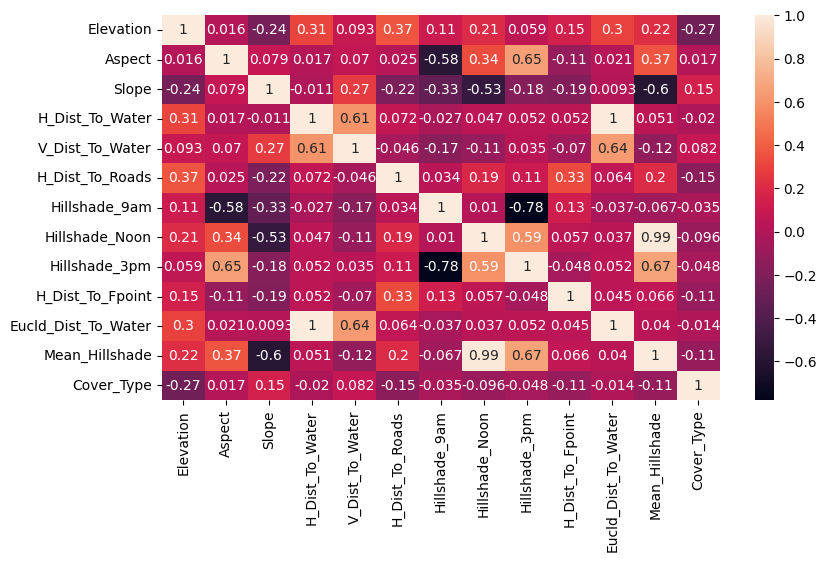

In [12]:
# Define correlation matrix from continuous features
corr_mat = cont_features.corr()

# Plot heatmap
plt.figure(figsize=(9,5))
sns.heatmap(corr_mat,annot=True)
plt.show()

Wilderness_Area and Soil_Type are one-hot encoded features of 4 and 40 parts respectively, can't carry out similar statistical tests.

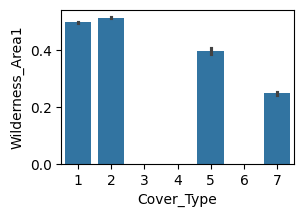

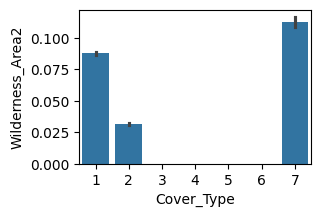

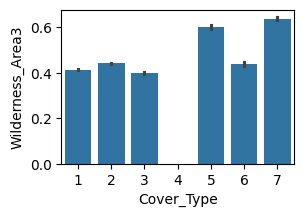

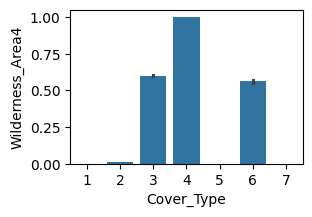

In [13]:
# Plotting general proportion plots for Wilderness_Area
for i in range(1,5):
    plt.figure(figsize=(3,2))
    sns.barplot(data=disc_features, y=f'Wilderness_Area{i}',x='Cover_Type')
    plt.show()

# SEM 2 IMPLEMENTATIONS

### 3. Feature Selection

In [13]:
# Updated dataframe (rescaled continuous features)
df_upd = pd.concat([cont_features.drop('Cover_Type',axis=1), disc_features], axis=1)
df_upd_X = df_upd.drop('Cover_Type',axis=1)
df_upd_y = df_upd['Cover_Type']

Performing a 80/10/10 split on the updated DataFrame for training, validation and test sets. However, this considers an imbalanced training set, thus the naming convention given as such.

This is to motivate wrapper-based and embedded feature selection, which require an explicit training set.

In [14]:
from sklearn.model_selection import train_test_split
X_train_df_upd_imbal, X_temp_df_upd_imbal, y_train_df_upd_imbal, y_temp_df_upd_imbal = train_test_split(df_upd_X, df_upd_y, 
                                                                                                train_size=0.8, 
                                                                                                shuffle=True,
                                                                                                # stratify=df_upd_y,
                                                                                                random_state=42)

X_valid_df_upd_imbal, X_test_df_upd_imbal, y_valid_df_upd_imbal, y_test_df_upd_imbal = train_test_split(X_temp_df_upd_imbal, y_temp_df_upd_imbal, 
                                                                                                train_size=0.5, 
                                                                                                shuffle=True,
                                                                                                # stratify=y_temp_df_upd_imbal,
                                                                                                random_state=42)

# NOTE: This selects 80% of examples from each label for training set, followed by 10% for both validation & test sets

Custom undersampling to split df_upd, ensuring equal label proportions in training and validation sets. 

In [15]:
# Extract observations with label of smallest proportion (in this case, Cover_Type4)
grp4 = df_upd.loc[df_upd['Cover_Type']==4]

# Split observations into 80/10/10  proportions
grp4_train, grp4_valid, grp4_test = np.split(grp4, [int(0.8*len(grp4)),int(0.9*len(grp4))])

# Identify length of grp4_train & grp4_valid to have even number of observations from other groups for model training and evaluation
print(f'Observations from Cover_Type4 for training: {len(grp4_train)}')
print(f'Observations from Cover_Type4 for validation: {len(grp4_valid)}\n')

# Obtain the observations from remaining Cover_Types for splitting into training, validation and test sets
grp1 = df_upd.loc[df_upd['Cover_Type']==1]
grp2 = df_upd.loc[df_upd['Cover_Type']==2]
grp3 = df_upd.loc[df_upd['Cover_Type']==3]
grp5 = df_upd.loc[df_upd['Cover_Type']==5]
grp6 = df_upd.loc[df_upd['Cover_Type']==6]
grp7 = df_upd.loc[df_upd['Cover_Type']==7]

# Defining the training, validation and test sets
train = pd.DataFrame(); valid = pd.DataFrame(); test = pd.DataFrame()
groups = [grp1, grp2, grp3, grp4, grp5, grp6, grp7]

for i, dataframe in enumerate(groups):
    # Obtain the indices of the dataframe based on its given Cover_Type value
    total_numbers = sorted(dataframe.index.values)

    # Randomly sample numbers for training set, append corresponding observations into final training set
    random.seed(42)
    train_indices = random.sample(total_numbers, len(grp4_train))
    train = pd.concat([train, dataframe.loc[train_indices]], ignore_index=True)

    # Create a list of leftover indices to split further into validation and test sets
    leftover_indices = [num for num in total_numbers if num not in train_indices]

    # Randomly sample numbers for validation set, append corresponding observations into final validation set
    random.seed(42)
    valid_indices = random.sample(leftover_indices, len(grp4_valid))
    valid = pd.concat([valid, dataframe.loc[valid_indices]], ignore_index=True)

    # Leftover numbers are assigned to the test set, append corresponding observations into the final test set
    test_indices = [num for num in leftover_indices if num not in valid_indices]
    test = pd.concat([test, dataframe.loc[test_indices]], ignore_index=True)

    # Print number of observations elements of the sampled and remainder lists for verification
    print(f'Cover Type {i+1}    [Training Set: {len(train_indices)}   Validation Set: {len(valid_indices)}   Test Set: {len(test_indices)}]\n')

# Shuffle observations in newly-updated training, validation, and test sets
train_df_upd = train.sample(frac=1,random_state=42)
valid_df_upd = valid.sample(frac=1,random_state=42)
test_df_upd = test.sample(frac=1,random_state=42)

### NOTE: Validation set does not necessarily need to be balanced, as it is just supposed to 'mimic' the test data...

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Observations from Cover_Type4 for training: 2197
Observations from Cover_Type4 for validation: 275

Cover Type 1    [Training Set: 2197   Validation Set: 275   Test Set: 209368]

Cover Type 2    [Training Set: 2197   Validation Set: 275   Test Set: 280829]

Cover Type 3    [Training Set: 2197   Validation Set: 275   Test Set: 33282]

Cover Type 4    [Training Set: 2197   Validation Set: 275   Test Set: 275]

Cover Type 5    [Training Set: 2197   Validation Set: 275   Test Set: 7021]

Cover Type 6    [Training Set: 2197   Validation Set: 275   Test Set: 14895]

Cover Type 7    [Training Set: 2197   Validation Set: 275   Test Set: 18038]



In [16]:
# Train/Valid/Test splits on df_upd (updated dataframe with rescaled continuous features)
X_train_df_upd_bal = train_df_upd.drop('Cover_Type',axis=1); y_train_df_upd_bal = train_df_upd['Cover_Type']
X_valid_df_upd_bal = valid_df_upd.drop('Cover_Type',axis=1); y_valid_df_upd_bal = valid_df_upd['Cover_Type']
X_test_df_upd_bal = test_df_upd.drop('Cover_Type',axis=1); y_test_df_upd_bal = test_df_upd['Cover_Type']

Instead of one-hot-encoding, combine all relevant columns for Wilderness_Area and Soil_Type respectively. This is for more visible insight on whether the discrete features as a whole are important towards classification, rather than each of their parts.

In [17]:
# Combining all one-hot encoded columns for Wilderness_Area and Soil_Type respectively
WA_range = np.arange(1,5); ST_range = np.arange(1,41)
for dataframe in [X_train_df_upd_imbal, X_valid_df_upd_imbal, X_test_df_upd_imbal,
                  X_train_df_upd_bal, X_valid_df_upd_bal, X_test_df_upd_bal, df_upd]:
    # Add combined columns
    dataframe['Wilderness_Area'] = dataframe[WA_columns].values.dot(WA_range)
    dataframe['Soil_Type'] = dataframe[ST_columns].values.dot(ST_range)

    # Drop previous OHE columns
    dataframe.drop(WA_columns,axis=1,inplace=True)
    dataframe.drop(ST_columns,axis=1,inplace=True)

df_upd_X = df_upd.drop('Cover_Type',axis=1)
df_upd_y = df_upd['Cover_Type']

Conducting wrapper-based feature selection

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
SFS = SequentialFeatureSelector(estimator = RandomForestClassifier(n_jobs=-1,random_state=42),
                                 n_features_to_select = 7,
                                 direction = 'forward',
                                 scoring = 'f1_macro',
                                 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
SFS.fit(X_train_df_upd_imbal,y_train_df_upd_imbal)
SFS.get_feature_names_out()

array(['Elevation', 'Aspect', 'H_Dist_To_Roads', 'H_Dist_To_Fpoint',
       'Eucld_Dist_To_Water', 'Wilderness_Area', 'Soil_Type'],
      dtype=object)

In [101]:
SBS = SequentialFeatureSelector(estimator = RandomForestClassifier(n_jobs=-1,random_state=42),
                                 n_features_to_select = 7,
                                 direction = 'backward',
                                 scoring = 'f1_macro',
                                 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
SBS.fit(X_train_df_upd_imbal,y_train_df_upd_imbal)
SBS.get_feature_names_out()

array(['Elevation', 'H_Dist_To_Water', 'H_Dist_To_Roads', 'Hillshade_9am',
       'H_Dist_To_Fpoint', 'Wilderness_Area', 'Soil_Type'], dtype=object)

In [19]:
SFS_features =['Elevation', 'Aspect', 'H_Dist_To_Roads', 'H_Dist_To_Fpoint','Eucld_Dist_To_Water', 'Wilderness_Area', 'Soil_Type']
SBS_features =['Elevation', 'H_Dist_To_Water', 'H_Dist_To_Roads', 'Hillshade_9am', 'H_Dist_To_Fpoint', 'Wilderness_Area', 'Soil_Type']

In [20]:
sample_model = DecisionTreeClassifier(random_state=42).fit(X_train_df_upd_imbal[SFS_features],y_train_df_upd_imbal)
sample_model_ypreds = sample_model.predict(X_valid_df_upd_imbal[SFS_features])
print(f"SFS selected features performance: {f1_score(y_valid_df_upd_imbal,sample_model_ypreds,average='macro')}")

sample_model2 = DecisionTreeClassifier(random_state=42).fit(X_train_df_upd_imbal[SBS_features],y_train_df_upd_imbal)
sample_model2_ypreds = sample_model2.predict(X_valid_df_upd_imbal[SBS_features])
print(f"SBS selected features performance: {f1_score(y_valid_df_upd_imbal,sample_model2_ypreds,average='macro')}")

SFS selected features performance: 0.9070502625846472
SBS selected features performance: 0.9062758212311751


In [21]:
# SFS = SequentialFeatureSelector(estimator = DecisionTreeClassifier(random_state=42),
#                                  n_features_to_select = 7,
#                                  direction = 'forward',
#                                  scoring = 'f1_macro',
#                                  cv = 5) #StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
# SFS.fit(X_train_df_upd_imbal,y_train_df_upd_imbal)
# SFS.get_feature_names_out()

In [22]:
# SBS = SequentialFeatureSelector(estimator = DecisionTreeClassifier(random_state=42),
#                                  n_features_to_select = 7,
#                                  direction = 'backward',
#                                  scoring = 'f1_macro',
#                                  cv = 5) #StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
# SBS.fit(X_train_df_upd_imbal,y_train_df_upd_imbal)
# SBS.get_feature_names_out()

Embedded feature selection (Decision Tree Classifer feature importance)

Check #1: all features from df_upd

Check #2: conditioning on each soil type, perform feature importance with the remaining features excluding Soil_Type

Check #3: look at solely soil types to identify the top 15, followed by DTC feature importance viewing with resp. to those 15 soils

Check #4: add interactions of chosen soil types from Check #2 into df_upd, observe the importance (signify importance of interactions)

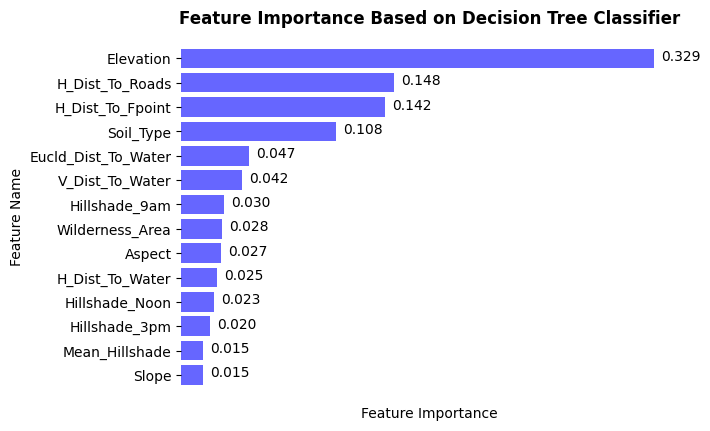

In [21]:
### Check #1
# Establish Decision Tree Classifier for identifying feature importance
DTC_ft_select_1 = DecisionTreeClassifier(random_state=42).fit(X_train_df_upd_imbal,y_train_df_upd_imbal)

# Create a DataFrame to hold feature importance based on their scores, select the top 10 scores of importance
feat_imp1 = pd.DataFrame(DTC_ft_select_1.feature_importances_, index=X_train_df_upd_imbal.columns).reset_index()
feat_imp1.columns=['feature','importance']
feat_imp1 = feat_imp1.nlargest(15,columns='importance')
n_selected_feats = len(feat_imp1.feature)

# Set up barplot with 10 bars, with lengths corresponding to that of the scores under feat_imp DataFrame defined earlier
bars = plt.barh(np.arange(n_selected_feats),feat_imp1['importance'].iloc[::-1],color='blue',alpha=0.6)

# Display scores for each of the top 10 important features 
for bar,name,value in zip(bars, list(feat_imp1['feature'].iloc[::-1]), list(feat_imp1['importance'].iloc[::-1])):
    plt.text((bar.get_width()+0.005),(bar.get_y()+0.32),'{:.3f}'.format(value))
# 'bar' iterates through the 10 rectangle/bar objects generated by plt.barh
# 'name' iterates through the names of the top 10 features selected
# 'value' iterates through the corresponding importance score for each of the top 10 features
# plt.text() adds text at certain coordinates. bar.get_width() returns length of bar from origin, bar.get_y() returns y-coord where it starts before plotting up 

plt.xticks([]); plt.yticks(np.arange(n_selected_feats),feat_imp1['feature'].iloc[::-1])
sns.despine(top=True, bottom=True,left=True)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Based on Decision Tree Classifier',fontweight='bold')
plt.show()

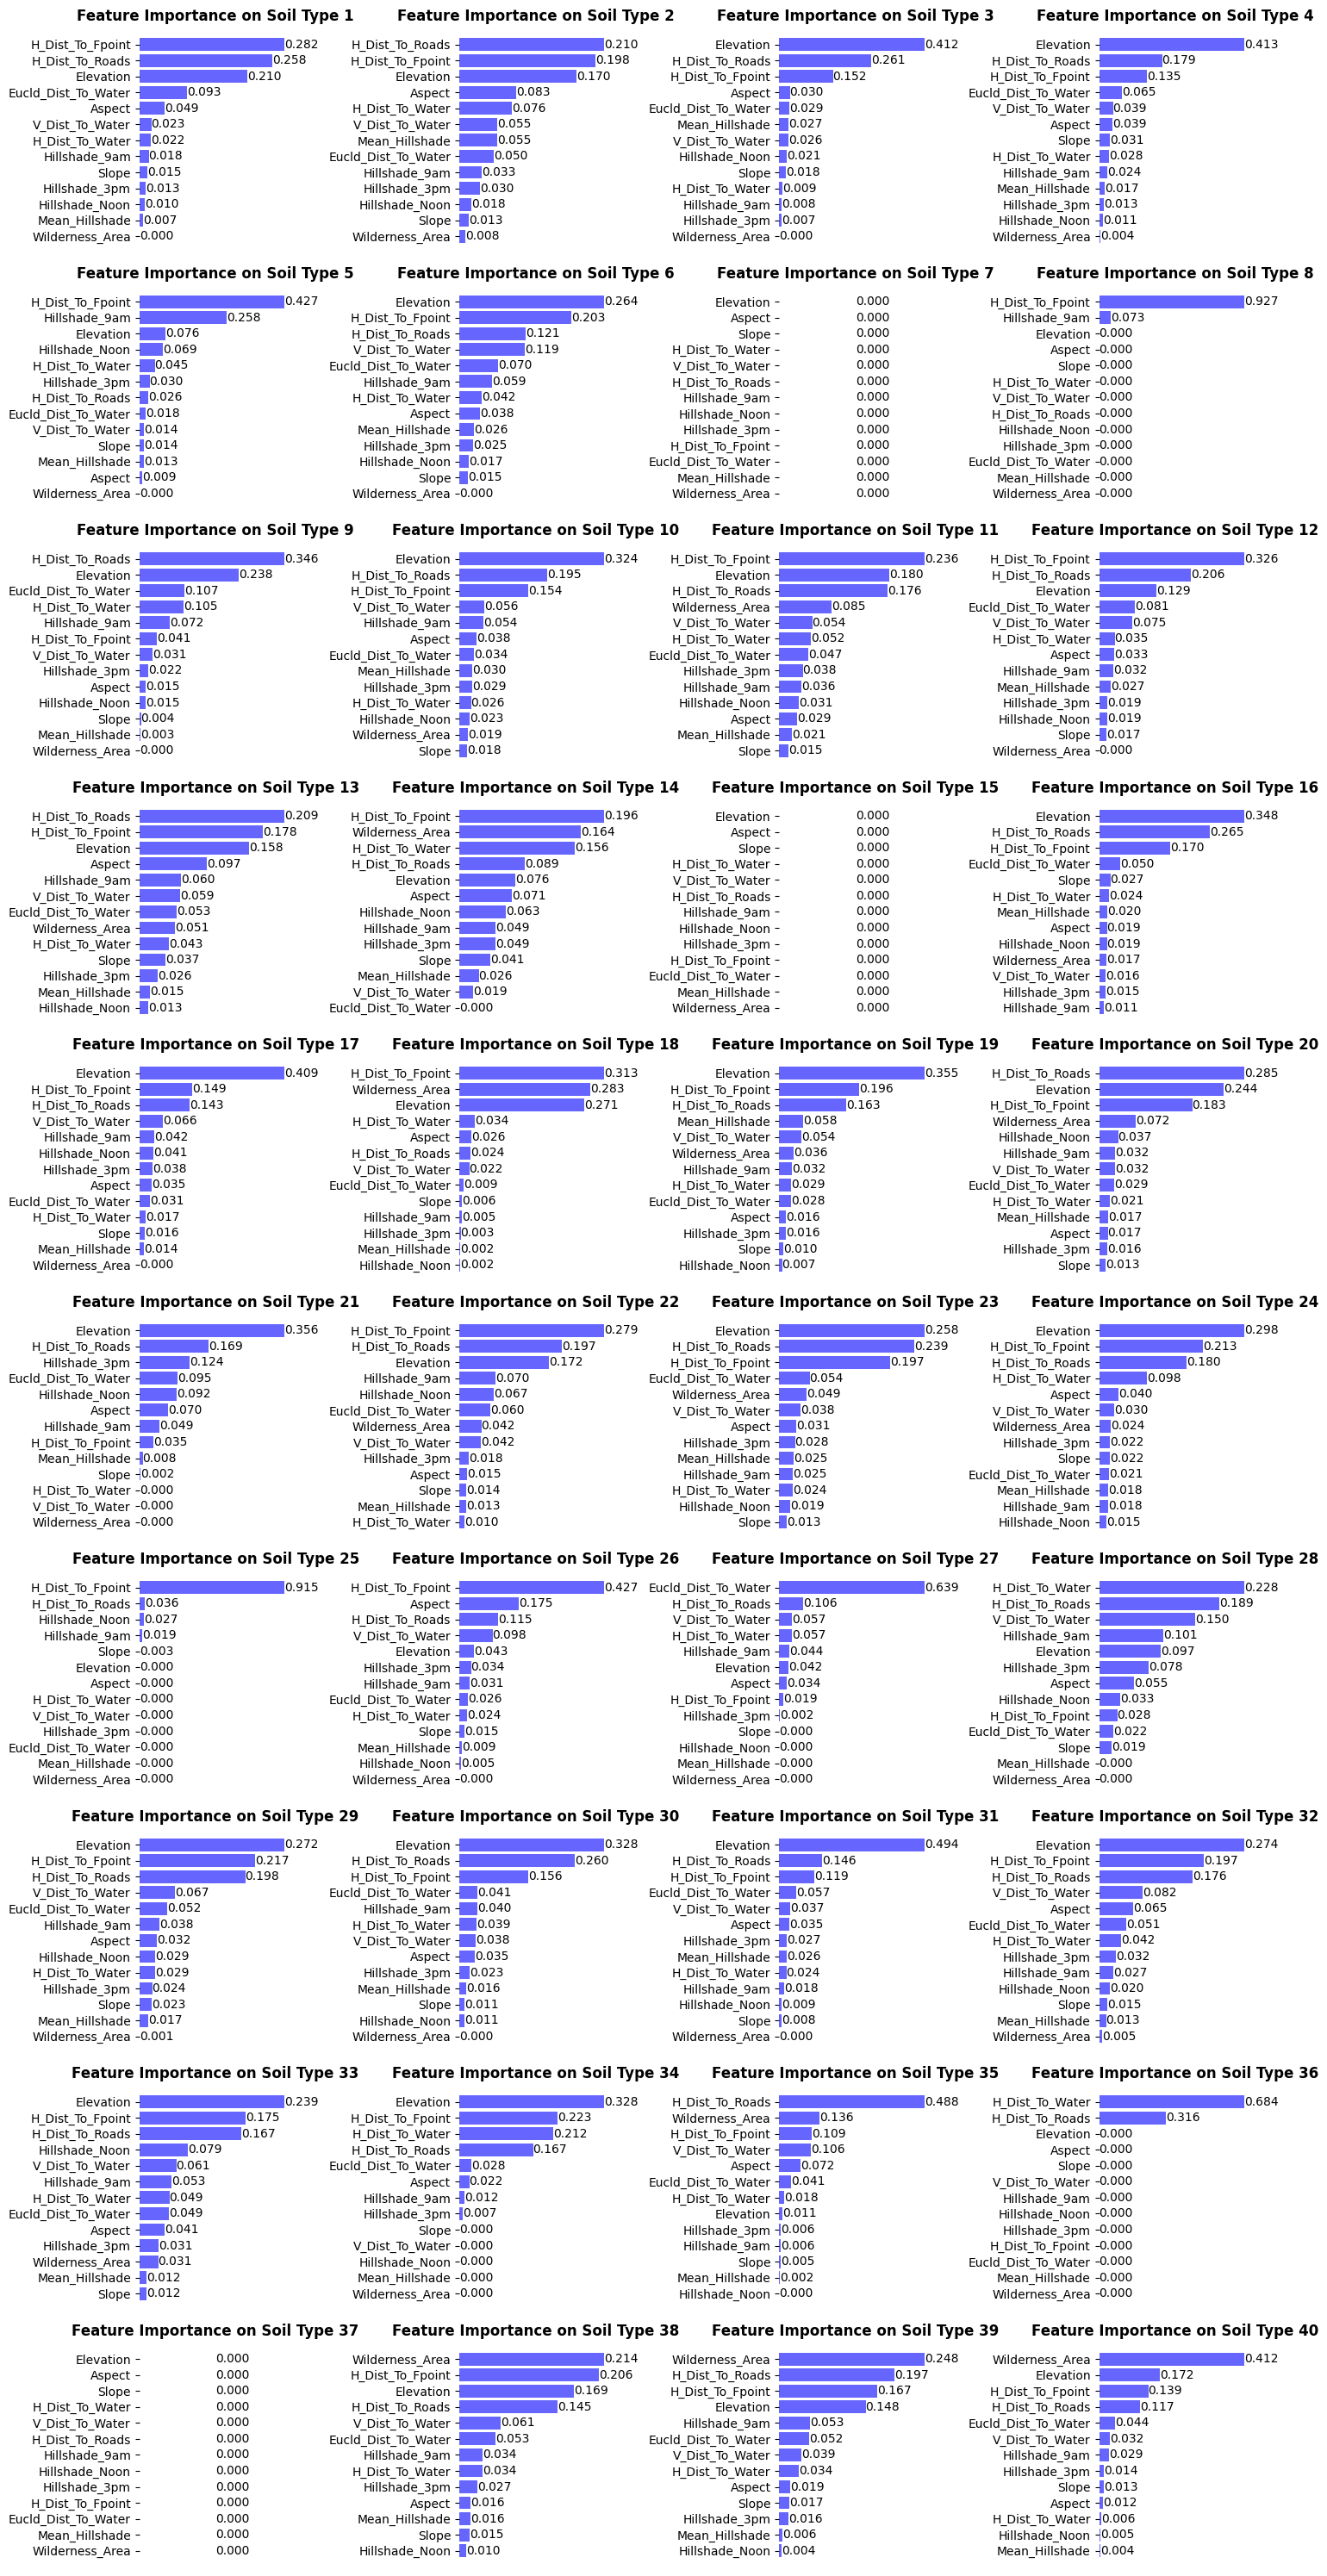

In [22]:
### Check #2
# Compile column names of all continuous features and Wilderness_Area in a list
list_of_features = cont_colnames.copy(); list_of_features.append('Wilderness_Area')

# Create separate DataFrame to store the sum of importances for all features
overall_importance = pd.DataFrame({'feature': list_of_features,'importance':np.zeros(len(list_of_features))})

# Initialize subplots for plotting DTC feature importance bar charts
fig, axs = plt.subplots(10, 4, figsize=(15, 30))
idx = 1

# Plots a DTC feature importance bar chart for each sample of Soil_Type taking values of 1 to 40
for i in range(10):
    for j in range(4):
        if idx<41:
            # Extract the observations such that Soil_Type has value 'idx'
            temp_set = df_upd.loc[df_upd['Soil_Type']==idx]
        
            # Separate according to X and y, followed by a general 70/30 split of the data
            X_soilbased_select = temp_set.drop(['Cover_Type','Soil_Type'],axis=1)
            y_soilbased_select = temp_set['Cover_Type']
            X_train_soil_select, X_rest_soil_select, y_train_soil_select, y_rest_soil_select = train_test_split(X_soilbased_select,y_soilbased_select,random_state=42,train_size=0.8)

            # Establish Decision Tree Classifier for identifying feature importance
            DTC_ft_select2 = DecisionTreeClassifier(random_state=42).fit(X_train_soil_select,y_train_soil_select,)

            # Create a DataFrame to hold feature importance based on their scores, select the top 10 scores of importance
            feat_imp=pd.DataFrame(DTC_ft_select2.feature_importances_, index=X_train_soil_select.columns).reset_index()
            feat_imp.columns=['feature','importance']
            feat_imp = feat_imp.nlargest(15,columns='importance')
            n_selected_feats = len(feat_imp.feature)

            # Plot bar chart in respective subplot
            axs[i,j].barh(np.arange(n_selected_feats),feat_imp['importance'].iloc[::-1],color='blue',alpha=0.6)
            axs[i,j].set_yticks(np.arange(n_selected_feats),feat_imp['feature'].iloc[::-1])
            axs[i,j].set_xticks([])
            axs[i,j].set_title(f'Feature Importance on Soil Type {idx}',fontweight='bold')
            for k, (name, value) in enumerate(zip(feat_imp['feature'].iloc[::-1],feat_imp['importance'].iloc[::-1])):
                axs[i,j].text(value,k,'{:.3f}'.format(value),ha='left',va='center')
            
            # Adds the importance value for each corresponding feature into that separate DataFrame
            overall_importance['importance'] += feat_imp['importance']

            # Iterate through idx every one step until all the graphs have been plotted
            idx += 1

# Remove axis lines and sufficiently spaces the graphs from each other
sns.despine(top=True, bottom=True,left=True)
plt.tight_layout()
plt.show()

In [23]:
overall_importance['importance'] = overall_importance['importance']/40
overall_importance.sort_values('importance',ascending=False)

,feature,importance
9,H_Dist_To_Fpoint,0.207268
0,Elevation,0.199457
5,H_Dist_To_Roads,0.169173
3,H_Dist_To_Water,0.059437
10,Eucld_Dist_To_Water,0.054467
12,Wilderness_Area,0.047576
4,V_Dist_To_Water,0.042367
6,Hillshade_9am,0.039162
1,Aspect,0.035371
8,Hillshade_3pm,0.022572


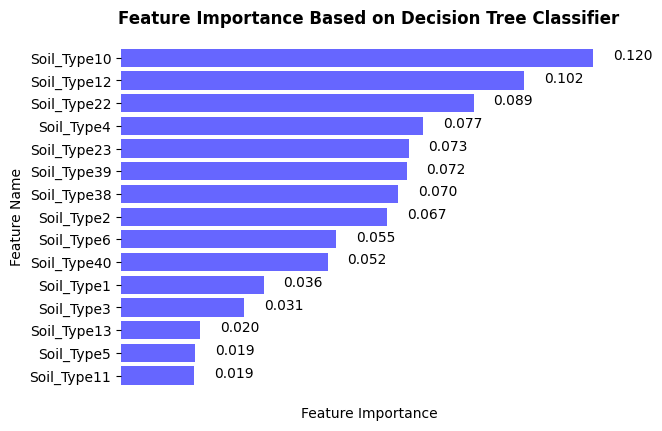

In [24]:
### Check #3
# Perform split for training set on solely 40 soil types
X_train_df_soil, X_rest_df_soil, y_train_df_soil, y_rest_df_soil = train_test_split(df_soil,df['Cover_Type'],random_state=42, test_size=0.2)

# Establish Decision Tree Classifier for identifying feature importance
DTC_ft_select_3 = DecisionTreeClassifier(random_state=42).fit(X_train_df_soil,y_train_df_soil)

# Create a DataFrame to hold feature importance based on their scores, select the top 10 scores of importance
feat_imp3 = pd.DataFrame(DTC_ft_select_3.feature_importances_, index=X_train_df_soil.columns).reset_index()
feat_imp3.columns=['feature','importance']
feat_imp3 = feat_imp3.nlargest(15,columns='importance')
n_selected_feats = len(feat_imp3.feature)

# Set up barplot with 10 bars, with lengths corresponding to that of the scores under feat_imp DataFrame defined earlier
bars = plt.barh(np.arange(n_selected_feats),feat_imp3['importance'].iloc[::-1],color='blue',alpha=0.6)

# Display scores for each of the top 10 important features 
for bar,name,value in zip(bars, list(feat_imp3['feature'].iloc[::-1]), list(feat_imp3['importance'].iloc[::-1])):
    plt.text((bar.get_width()+0.005),(bar.get_y()+0.32),'{:.3f}'.format(value))

plt.xticks([]); plt.yticks(np.arange(n_selected_feats),feat_imp3['feature'].iloc[::-1])
sns.despine(top=True, bottom=True,left=True)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Based on Decision Tree Classifier',fontweight='bold')
plt.show()

List of soil types with importance > 0.05 (Ordered in descending order of importance)

[10, 12, 22, 4, 23, 39, 38, 2, 6, 40]


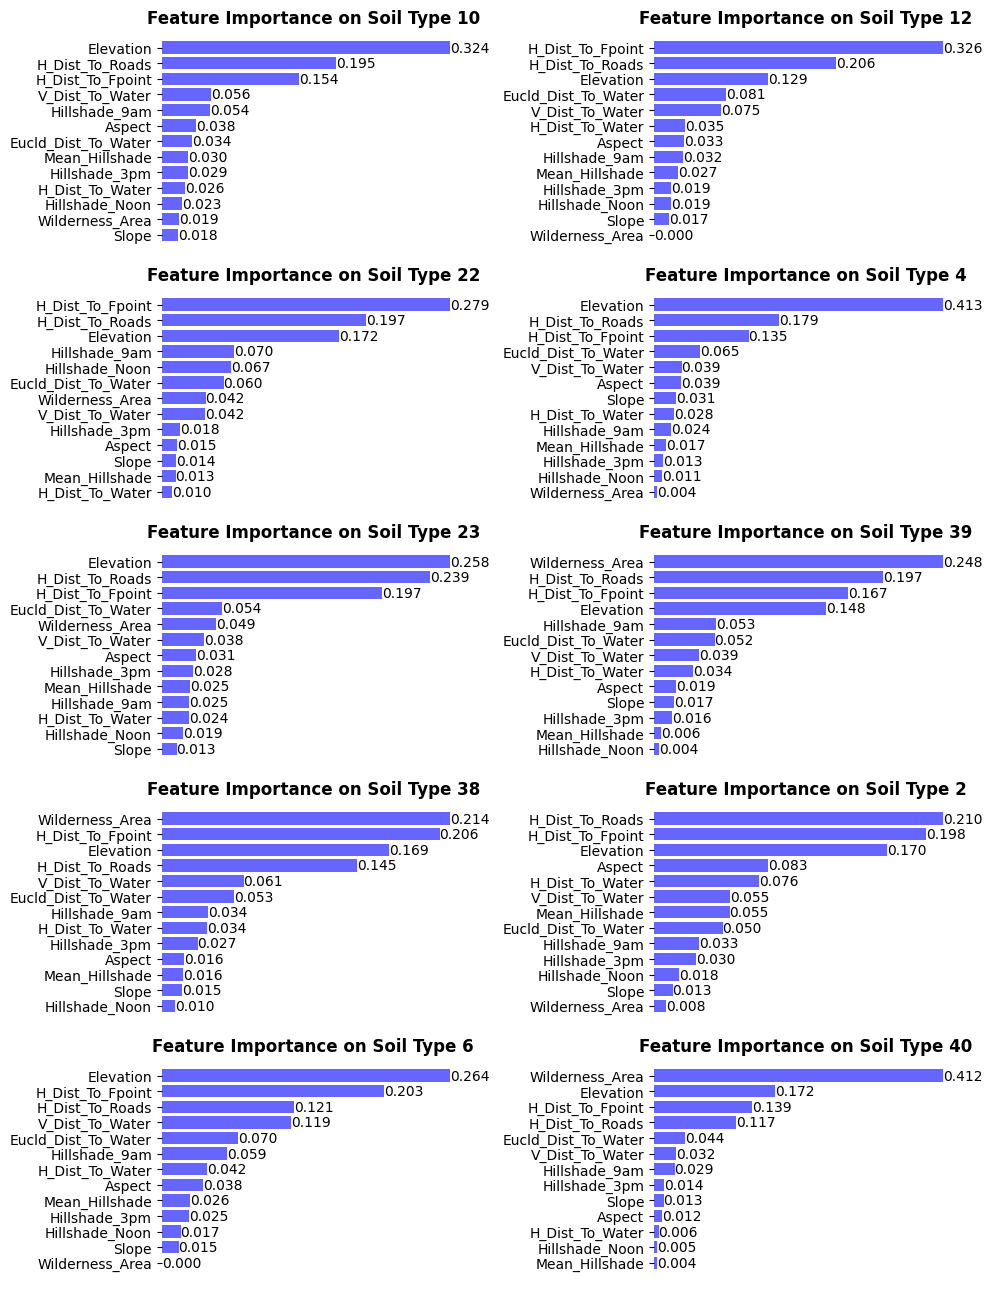

In [25]:
list_of_features = cont_colnames.copy(); list_of_features.append('Wilderness_Area')

# Create separate DataFrame to store the sum of importances for all features
overall_importance = pd.DataFrame({'feature': list_of_features,'importance':np.zeros(len(list_of_features))})

# Initialize subplots for plotting DTC feature importance bar charts
fig, axs = plt.subplots(5, 2, figsize=(10, 13))
soil_list = [10, 12, 22, 4, 23, 39, 38, 2, 6, 40]; idx = 0

# Plots a DTC feature importance bar chart for each sample of Soil_Type taking values of 1 to 40
for i in range(5):
    for j in range(2):
        if idx < 11:
            # Extract the observations such that Soil_Type has value 'idx'
            temp_set = df_upd.loc[df_upd['Soil_Type']==soil_list[idx]]
        
            # Separate according to X and y, followed by a general 70/30 split of the data
            X_soilbased_select = temp_set.drop(['Cover_Type','Soil_Type'],axis=1)
            y_soilbased_select = temp_set['Cover_Type']
            X_train_soil_select, X_rest_soil_select, y_train_soil_select, y_rest_soil_select = train_test_split(X_soilbased_select,y_soilbased_select,random_state=42,train_size=0.8)

            # Establish Decision Tree Classifier for identifying feature importance
            DTC_ft_select3b = DecisionTreeClassifier(random_state=42).fit(X_train_soil_select,y_train_soil_select)

            # Create a DataFrame to hold feature importance based on their scores, select the top 10 scores of importance
            feat_imp=pd.DataFrame(DTC_ft_select3b.feature_importances_, index=X_train_soil_select.columns).reset_index()
            feat_imp.columns=['feature','importance']
            feat_imp = feat_imp.nlargest(15,columns='importance')
            n_selected_feats = len(feat_imp.feature)

            # Plot bar chart in respective subplot
            axs[i,j].barh(np.arange(n_selected_feats),feat_imp['importance'].iloc[::-1],color='blue',alpha=0.6)
            axs[i,j].set_yticks(np.arange(n_selected_feats),feat_imp['feature'].iloc[::-1])
            axs[i,j].set_xticks([])
            axs[i,j].set_title(f'Feature Importance on Soil Type {soil_list[idx]}',fontweight='bold')
            for k, (name, value) in enumerate(zip(feat_imp['feature'].iloc[::-1],feat_imp['importance'].iloc[::-1])):
                axs[i,j].text(value,k,'{:.3f}'.format(value),ha='left',va='center')
            
            # Adds the importance value for each corresponding feature into that separate DataFrame
            overall_importance['importance'] += feat_imp['importance']

            # Iterate through idx every one step until all the graphs have been plotted
            idx += 1

# Remove axis lines and sufficiently spaces the graphs from each other
sns.despine(top=True, bottom=True,left=True)
plt.tight_layout()
plt.show()

In [26]:
overall_importance['importance'] = overall_importance['importance']/10
overall_importance.sort_values('importance',ascending=False)

,feature,importance
0,Elevation,0.221854
9,H_Dist_To_Fpoint,0.200649
5,H_Dist_To_Roads,0.180824
12,Wilderness_Area,0.099748
10,Eucld_Dist_To_Water,0.056343
4,V_Dist_To_Water,0.055499
6,Hillshade_9am,0.041420
1,Aspect,0.032297
3,H_Dist_To_Water,0.031522
8,Hillshade_3pm,0.021955


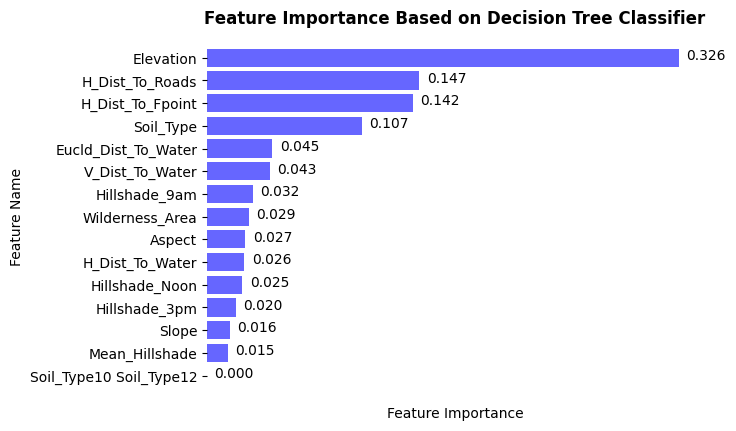

In [27]:
### Check #4
from sklearn.preprocessing import PolynomialFeatures
PolyFeat = PolynomialFeatures(2, interaction_only=True, include_bias=False)

selected_soil_types = []
for idx in [10, 12, 22, 4, 23, 39, 38, 2, 6, 40]:
    selected_soil_types.append('Soil_Type' + str(idx))

# Extract all necessary features for desired soil type DataFrames
df_soil_reduced = df_soil.loc[:,selected_soil_types] # Slice df_soil based on selected soil types from Check #3

# Create interaction terms between the importance selected soil types
X_interactions_reduced = PolyFeat.fit_transform(df_soil_reduced)
inter_feats_names = PolyFeat.get_feature_names_out(input_features=df_soil_reduced.columns)
df_soil_w_inters = pd.DataFrame(X_interactions_reduced, columns=inter_feats_names)

# Adding the interaction terms into the updated DataFrame (df_upd)
df_upd_w_inters = pd.concat([df_upd,df_soil_w_inters.drop(selected_soil_types,axis=1)],axis=1)

# Split training set from the new updated DataFrame and fit DTC model
X_train_df_upd_inters, X_rest_df_upd_inters, y_train_df_upd_inters, y_rest_df_upd_inters = train_test_split(df_upd_w_inters.drop('Cover_Type',axis=1),
                                                                                                            df_upd_w_inters['Cover_Type'], train_size=0.8)
DTC_ft_select_4 = DecisionTreeClassifier(random_state=42).fit(X_train_df_upd_inters,y_train_df_upd_inters)

# Create a DataFrame to hold feature importance based on their scores, select the top 10 scores of importance
feat_imp4 = pd.DataFrame(DTC_ft_select_4.feature_importances_, index=X_train_df_upd_inters.columns).reset_index()
feat_imp4.columns=['feature','importance']
feat_imp4 = feat_imp4.nlargest(15,columns='importance')
n_selected_feats = len(feat_imp4.feature)

# Set up barplot with 10 bars, with lengths corresponding to that of the scores under feat_imp DataFrame defined earlier
bars = plt.barh(np.arange(n_selected_feats),feat_imp4['importance'].iloc[::-1],color='blue',alpha=0.6)

# Display scores for each of the top 10 important features 
for bar,name,value in zip(bars, list(feat_imp4['feature'].iloc[::-1]), list(feat_imp4['importance'].iloc[::-1])):
    plt.text((bar.get_width()+0.005),(bar.get_y()+0.32),'{:.3f}'.format(value))

plt.xticks([]); plt.yticks(np.arange(n_selected_feats),feat_imp4['feature'].iloc[::-1])
sns.despine(top=True, bottom=True,left=True)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Based on Decision Tree Classifier',fontweight='bold')
plt.show()

OVERALL FINDINGS FROM SECTION 3
Wrapper-based Methods



Embedded Methods

Check 1:
- Soil_Type is, in fact, an important feature in making predictions
- Elevation has the highest importance among all other features
- Considering features where importance > 0.05, select [Elevation, H_Dist_To_Fpoint, H_Dist_To_Roads, Hillshade_9am, Soil_Type]

Check 2:
- Elevation, H_Dist_To_Fpoint and H_Dist_To_Roads undoubtedly have highest average importance among other features
- Soil Type 7, 15, 37 to be excluded (no information obtained under all continuous features)
- Considering features where importance > 0.05, select [Elevation, H_Dist_To_Fpoint, H_Dist_To_Roads, H_Dist_To_Water, Eucld_Dist_To_Water]

Check 3:
- Considering solely soil types, the following soil types are selected with importance > 0.05, [10, 12, 22, 4, 23, 39, 38, 2, 6, 40]
- Observing importance plots of chosen soil types, Elevation has highest average importance, followed by H_Dist_To_Fpoint and H_Dist_To_Roads
- Considering features where importance > 0.05, select [Elevation, H_Dist_To_Fpoint, H_Dist_To_Roads, V_Dist_To_Water, Eucld_Dist_To_Water, Wilderness_Area]

Check 4:
- Soil type interactions appear to not have any importance in making predictions towards cover type
- Only interaction between Soil_Type10 and Soil_Type12 is selected among top 15, yet has negligible importance
- Considering features where importance > 0.05, select [Elevation, H_Dist_To_Fpoint, H_Dist_To_Roads, Soil_Type]

In [28]:
final_selected_feats = ['Elevation', 'H_Dist_To_Roads', 'H_Dist_To_Fpoint', 'Soil_Type']

X_train_df_upd_imbal = X_train_df_upd_imbal.loc[:,final_selected_feats]
X_valid_df_upd_imbal = X_valid_df_upd_imbal.loc[:,final_selected_feats]
X_test_df_upd_imbal = X_test_df_upd_imbal.loc[:,final_selected_feats]

X_train_df_upd_bal = X_train_df_upd_bal.loc[:,final_selected_feats]
X_valid_df_upd_bal = X_valid_df_upd_bal.loc[:,final_selected_feats]
X_test_df_upd_bal = X_test_df_upd_bal.loc[:,final_selected_feats]

df_upd = df_upd.loc[:,final_selected_feats]
df_upd['Cover_Type'] = df['Cover_Type']

### 4. Data Splitting & Resampling

Oversampling can be good for models that involve iteratively learning coefficients (ANN with SGD)

Oversampling can also be good for models that seek good data splits (SVM, DTC)

However, in case of severe label imbalance, can lead to increased generalization error, due to overfitting minority class

In [29]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

ROS_object = RandomOverSampler(random_state=42)
RUS_object = RandomUnderSampler(random_state=42)
SMOTE_object = SMOTE(random_state=42)
ADASYN_object = ADASYN(random_state=42)
TL_object = TomekLinks()
SMOTEENN_object = SMOTEENN(random_state=42)
SMOTE_Tomek_object = SMOTETomek(random_state=42)

In [30]:
methods_used = ['ROS', 'RUS', 'SMOTE', 'ADASYN', 'TL', 'SMOTEENN', 'CustomUS']

# Random Oversampling dataset
ROS_X_train, ROS_y_train = ROS_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# Random Undersampling dataset
RUS_X_train, RUS_y_train = RUS_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# SMOTE Oversampling dataset
SMOTE_X_train, SMOTE_y_train = SMOTE_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# ADASYN Hybrid Sampling dataset
ADASYN_X_train, ADASYN_y_train = ADASYN_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# Tomek Links Undersampling dataset
TL_X_train, TL_y_train = TL_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# SMOTE Edited Nearest Neighbors Hybrid Sampling dataset
SMOTEENN_X_train, SMOTEENN_y_train = SMOTEENN_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)

# SMOTE Tomek Hybrid Sampling dataset
# SMOTE_Tomek_X_train, SMOTE_Tomek_y_train = SMOTE_Tomek_object.fit_resample(X_train_df_upd_imbal,y_train_df_upd_imbal)


In [30]:
for name, data in zip(methods_used,[ROS_y_train, RUS_y_train, SMOTE_y_train, ADASYN_y_train, TL_y_train, SMOTEENN_y_train,y_train_df_upd_bal]):
    print(f'Proportions from {name}')
    print(f'{data.value_counts()}\n')

Proportions from ROS
Cover_Type
1    226801
2    226801
3    226801
7    226801
6    226801
5    226801
4    226801
Name: count, dtype: int64

Proportions from RUS
Cover_Type
1    2221
2    2221
3    2221
4    2221
5    2221
6    2221
7    2221
Name: count, dtype: int64

Proportions from SMOTE
Cover_Type
1    226801
2    226801
3    226801
7    226801
6    226801
5    226801
4    226801
Name: count, dtype: int64

Proportions from ADASYN
Cover_Type
1    230097
3    227359
7    227055
2    226801
4    226623
6    226563
5    225961
Name: count, dtype: int64

Proportions from TL
Cover_Type
2    219617
1    163047
3     26809
7     15915
6     12338
5      6756
4      2221
Name: count, dtype: int64

Proportions from SMOTEENN
Cover_Type
7    226081
5    225787
4    224786
6    221676
3    220146
1    205453
2    199686
Name: count, dtype: int64

Proportions from CustomUS
Cover_Type
2    2197
3    2197
6    2197
7    2197
4    2197
5    2197
1    2197
Name: count, dtype: int64



### 5. Model Selection

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [32]:
class_weights = {}
class_frequencies = {1: 211840, 2: 283301, 3: 35754, 4: 2747,
                     5: 9493, 6: 17367, 7: 20510}

# Calculate the total number of samples
total_samples = sum(class_frequencies.values())

# Calculate the class weights
for label, frequency in class_frequencies.items():
    class_weights[label] = total_samples / (len(class_frequencies) * frequency)
print("Class weights:", class_weights)

Class weights: {1: 0.391813228312473, 2: 0.292980661154441, 3: 2.321466529219508, 4: 30.215403817151177, 5: 8.743465109629652, 6: 4.77927761189119, 7: 4.046890018806157}


In [33]:
from sklearn.metrics import f1_score
# No need to consider class weights in any of the hyperparameter testing with GridSearchCV. This will be toggleable in the function.

DTC_hparams = {'criterion':['entropy', 'log_loss'],
               'splitter':['best', 'random'],
               'max_depth':[3,5,7,9,11]}

RFC_hparams = {'criterion':['entropy', 'log_loss'],
               'min_samples_split':[2,10,25,50],
               'max_depth':[3,5,7,9,11],
               'n_estimators':[20,50,70,100]}

# MLR will be focused on elastic net as it provides stricter weighting on the predictors in classification
MLR_hparams = {'l1_ratio':[0.3,0.5,0.7],
               'max_iter':[2500,5000],
               'tol':[0.0005, 0.001, 0.0025]}

# KIV for future fixing
XGBC_hparams = {'learning_rate':[0.2,0.5,0.8],
                'alpha':[0.25,0.5,0.75],
                'reg_lambda':[0.25,0.5,0.75],
                'gamma':[0,0.25, 0.5],
                'max_depth':[3,6,9,12]}

In [34]:
label_distribution = {1: 211840, 2: 283301, 3: 35754, 4: 2747, 5: 9493, 6: 17367, 7: 20510}
total_samples = sum(label_distribution.values())

# Base cost for correct classifications
base_cost = 0

# Create the cost matrix
num_classes = len(label_distribution)
cost_matrix = np.zeros((num_classes, num_classes))

# Assign costs based on label distribution
for true_label, true_label_count in label_distribution.items():
    for pred_label, pred_label_count in label_distribution.items():
        if true_label == pred_label:
            # Correct classification (base cost)
            cost_matrix[true_label-1, pred_label-1] = base_cost
        else:
            # Misclassification
            cost_matrix[true_label-1, pred_label-1] = true_label_count / total_samples

In [35]:
def iterative_hparams_tuning(estimator, hparam_dict, X_train, y_train, X_test, y_test):
    import itertools
    from sklearn.metrics import log_loss, f1_score

    # Set up lists to compile in a DataFrame
    f1_scores_list = []; hparams_combinations = []; cost_list = []

    # Iterate over hyperparameters
    for param_values in itertools.product(*hparam_dict.values()):
        params = dict(zip(hparam_dict.keys(), param_values))
        hparams_combinations.append(params)

        # Set the hyperparameters of the model
        estimator.set_params(**params)
        
        # Train the model on the training data
        estimator.fit(X_train,y_train)
        
        # Get predictions and their corresponding probabilities
        ypreds = estimator.predict(X_test)
        ypred_probas = estimator.predict_proba(X_test)

        f1score = f1_score(y_test,ypreds,average='macro')
        f1_scores_list.append(f1score)

        cost = log_loss(y_test,ypred_probas)
        cost_list.append(cost)
    
    # Compile all recorded metrics and hyperparameter combinations in a DataFrame
    pd.set_option('display.max_colwidth', None)
    return pd.DataFrame({'Hyperparameter Combination':hparams_combinations,
                         'F1-Macro Score':f1_scores_list,
                         'Cross Entropy':cost_list})


In [112]:
DTC_model = DecisionTreeClassifier(random_state=42) # Class weights removed for hparam tuning
DTC_summary = iterative_hparams_tuning(DTC_model,DTC_hparams,X_train_df_upd_imbal,y_train_df_upd_imbal,
                                       X_valid_df_upd_imbal,y_valid_df_upd_imbal)
print(DTC_summary.sort_values('Cross Entropy',ascending=True)['Hyperparameter Combination'].head(1).values)
DTC_summary.sort_values('Cross Entropy',ascending=True).head(10)

[{'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 11}]


,Hyperparameter Combination,F1-Macro Score,Cross Entropy
14,"{'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 11}",0.699023,0.542986
4,"{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11}",0.699023,0.542986
13,"{'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 9}",0.643562,0.575499
3,"{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9}",0.643562,0.575499
9,"{'criterion': 'entropy', 'splitter': 'random', 'max_depth': 11}",0.555636,0.602086
19,"{'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 11}",0.555636,0.602086
12,"{'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 7}",0.546145,0.641624
2,"{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7}",0.546145,0.641624
8,"{'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9}",0.529829,0.642713
18,"{'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 9}",0.529829,0.642713


In [125]:
RFC_model = RandomForestClassifier(random_state=42) # Class weights removed for hparam tuning
RFC_summary = iterative_hparams_tuning(RFC_model,RFC_hparams,X_train_df_upd_imbal,y_train_df_upd_imbal,
                                       X_valid_df_upd_imbal,y_valid_df_upd_imbal)
print(RFC_summary.sort_values('Cross Entropy',ascending=True)['Hyperparameter Combination'].head(1).values)
RFC_summary.sort_values('Cross Entropy',ascending=True).head(10)

[{'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 11, 'n_estimators': 100}]


,Hyperparameter Combination,F1-Macro Score,Cross Entropy
19,"{'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 11, 'n_estimators': 100}",0.717563,0.470816
99,"{'criterion': 'log_loss', 'min_samples_split': 2, 'max_depth': 11, 'n_estimators': 100}",0.717563,0.470816
18,"{'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 11, 'n_estimators': 70}",0.717811,0.471250
98,"{'criterion': 'log_loss', 'min_samples_split': 2, 'max_depth': 11, 'n_estimators': 70}",0.717811,0.471250
119,"{'criterion': 'log_loss', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 100}",0.717381,0.472036
39,"{'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 100}",0.717381,0.472036
38,"{'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 70}",0.715705,0.472148
118,"{'criterion': 'log_loss', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 70}",0.715705,0.472148
37,"{'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 50}",0.713357,0.472547
117,"{'criterion': 'log_loss', 'min_samples_split': 10, 'max_depth': 11, 'n_estimators': 50}",0.713357,0.472547


In [40]:
MLR_model = LogisticRegression(penalty='elasticnet', fit_intercept=False, multi_class='multinomial',solver='saga',
                               random_state=42) # Class weights removed for hparam tuning
MLR_summary = iterative_hparams_tuning(MLR_model,MLR_hparams,X_train_df_upd_imbal,y_train_df_upd_imbal,
                                       X_valid_df_upd_imbal,y_valid_df_upd_imbal)
print(MLR_summary.sort_values('Cross Entropy',ascending=True)['Hyperparameter Combination'].head(1).values)
MLR_summary.sort_values('Cross Entropy',ascending=True).head(10)

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/a

[{'l1_ratio': 0.7, 'max_iter': 2500, 'tol': 0.001}]


,Hyperparameter Combination,F1-Macro Score,Cross Entropy
13,"{'l1_ratio': 0.7, 'max_iter': 2500, 'tol': 0.001}",0.345679,1.247196
12,"{'l1_ratio': 0.7, 'max_iter': 2500, 'tol': 0.0...",0.345679,1.247196
17,"{'l1_ratio': 0.7, 'max_iter': 5000, 'tol': 0.0...",0.338537,1.274229
14,"{'l1_ratio': 0.7, 'max_iter': 2500, 'tol': 0.0...",0.338537,1.274229
0,"{'l1_ratio': 0.3, 'max_iter': 2500, 'tol': 0.0...",0.332605,1.316512
1,"{'l1_ratio': 0.3, 'max_iter': 2500, 'tol': 0.001}",0.332605,1.316512
6,"{'l1_ratio': 0.5, 'max_iter': 2500, 'tol': 0.0...",0.329381,1.324446
7,"{'l1_ratio': 0.5, 'max_iter': 2500, 'tol': 0.001}",0.329381,1.324446
8,"{'l1_ratio': 0.5, 'max_iter': 2500, 'tol': 0.0...",0.329381,1.324446
11,"{'l1_ratio': 0.5, 'max_iter': 5000, 'tol': 0.0...",0.326304,1.327911


In [113]:
XGBC_model = xgb.XGBClassifier(objective='multi:softmax', seed=42, tree_method='hist', booster='gbtree',num_class=7)
XGBC_summary = iterative_hparams_tuning(XGBC_model,XGBC_hparams,X_train_df_upd_imbal,y_train_df_upd_imbal-1,
                                       X_valid_df_upd_imbal,y_valid_df_upd_imbal-1)
print(XGBC_summary.sort_values('Cross Entropy',ascending=True)['Hyperparameter Combination'].head(1).values)
XGBC_summary.sort_values('Cross Entropy',ascending=True).head(10)

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred value

[{'learning_rate': 0.8, 'alpha': 0.75, 'reg_lambda': 0.75, 'gamma': 0, 'max_depth': 12}]


,Hyperparameter Combination,F1-Macro Score,Cross Entropy
315,"{'learning_rate': 0.8, 'alpha': 0.75, 'reg_lambda': 0.75, 'gamma': 0, 'max_depth': 12}",0.880595,0.156948
291,"{'learning_rate': 0.8, 'alpha': 0.75, 'reg_lambda': 0.25, 'gamma': 0, 'max_depth': 12}",0.879157,0.157667
303,"{'learning_rate': 0.8, 'alpha': 0.75, 'reg_lambda': 0.5, 'gamma': 0, 'max_depth': 12}",0.876011,0.157766
183,"{'learning_rate': 0.5, 'alpha': 0.75, 'reg_lambda': 0.25, 'gamma': 0, 'max_depth': 12}",0.877386,0.157799
207,"{'learning_rate': 0.5, 'alpha': 0.75, 'reg_lambda': 0.75, 'gamma': 0, 'max_depth': 12}",0.876538,0.158215
195,"{'learning_rate': 0.5, 'alpha': 0.75, 'reg_lambda': 0.5, 'gamma': 0, 'max_depth': 12}",0.878080,0.158622
279,"{'learning_rate': 0.8, 'alpha': 0.5, 'reg_lambda': 0.75, 'gamma': 0, 'max_depth': 12}",0.876250,0.160013
147,"{'learning_rate': 0.5, 'alpha': 0.5, 'reg_lambda': 0.25, 'gamma': 0, 'max_depth': 12}",0.877753,0.160054
159,"{'learning_rate': 0.5, 'alpha': 0.5, 'reg_lambda': 0.5, 'gamma': 0, 'max_depth': 12}",0.878802,0.160713
171,"{'learning_rate': 0.5, 'alpha': 0.5, 'reg_lambda': 0.75, 'gamma': 0, 'max_depth': 12}",0.877741,0.160928


### 6. Model Evaluation

In [70]:
def confusion_matrix_7by7(y_true, y_pred):
    unique_labels = sorted(np.unique(y_true))
    num_classes = len(unique_labels)
    cm = np.zeros((num_classes, num_classes))

    for true_label, pred_label in zip(y_true, y_pred):
        cm[int(true_label)-1, int(pred_label)-1] += 1
    ''' This pairs up the y_true and y_pred with each other. Then based on their value, a one is added to their corresponding index in 
        matrix. This removes the need to manually sift through each pair of correctly- and wrongly-classified labels.'''
    return np.array(cm).astype(int)
            # pd.DataFrame(cm, index=unique_labels, columns=unique_labels).map(int)


def cost_matrix_7by7(y_true, y_pred, risk_matters = False):
    if risk_matters is False:
        # Cost matrix has all entries as 1 to signify equal risk, while diagonal maintains as 0
        default_cost_matrix =  np.full((7, 7), 1)
        np.fill_diagonal(default_cost_matrix, 0)

    else: # Need to change so that the values are an input to suit data
        default_cost_matrix = np.array([[0,1,2,1,1,5,6],
                                        [1,0,1,1,1,4,5],
                                        [2,1,0,1,1,3,4],
                                        [5,5,5,0,5,5,5],
                                        [4,3,2,1,0,1,2],
                                        [5,4,3,1,1,0,1],
                                        [6,5,4,1,2,1,0]])
    unique_labels = sorted(np.unique(y_true))
    num_classes = len(default_cost_matrix)
    cost_matrix_result = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            # Compute the cost based on misclassifications
            cost_matrix_result[i, j] = default_cost_matrix[i, j] * np.sum((y_true == i+1) & (y_pred == j+1))
        
    return pd.DataFrame(cost_matrix_result, index=unique_labels, columns=unique_labels).map(int)

In [63]:
def fit_predict_DTC(X_train, y_train, X_test, class_weight=None):
    DTC_model = DecisionTreeClassifier(random_state=42, criterion='entropy', splitter='best', max_depth=11,
                                        class_weight=class_weight).fit(X_train, y_train)
    print('Fitting complete')
    y_pred = DTC_model.predict(X_test)
    return y_pred

def fit_predict_RFC(X_train, y_train, X_test, class_weight=None):
    RFC_model = RandomForestClassifier(random_state=42,min_samples_split=2,criterion='entropy',max_depth=11,
                                       class_weight=class_weight).fit(X_train, y_train)
    print('Fitting complete')
    y_pred = RFC_model.predict(X_test)
    return y_pred

def fit_predict_MLR(X_train, y_train, X_test, class_weight=None):
    MLR_model = LogisticRegression(penalty='elasticnet', fit_intercept=False, multi_class='multinomial',solver='saga', l1_ratio=0.7,
                                   max_iter=2500, tol=0.001, class_weight=class_weight, random_state=42).fit(X_train, y_train)
    print('Fitting complete')
    y_pred = MLR_model.predict(X_test)
    return y_pred

def fit_predict_XGBC(X_train, y_train, X_test, class_weight=None):
    y_train_temp = y_train - 1
    XGB_model = xgb.XGBClassifier(tree_method='hist', multi_strategy = 'multi_output_tree', class_weight = class_weight,
                                  gamma = 0, learning_rate = 0.8, max_depth = 12, alpha = 0.75, 
                                  reg_lambda = 0.75).fit(X_train, y_train_temp)
    print('Fitting complete')
    y_pred = XGB_model.predict(X_test)
    return y_pred + 1

In [89]:
print('Classifier: DTC  |  Training Set: Rebalanced')
ROS_preds_DTC = fit_predict_DTC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal)
RUS_preds_DTC = fit_predict_DTC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal)
SMOTE_preds_DTC = fit_predict_DTC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal)
ADASYN_preds_DTC = fit_predict_DTC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal)
TL_preds_DTC = fit_predict_DTC(TL_X_train, TL_y_train,X_valid_df_upd_imbal)
SMOTEENN_preds_DTC = fit_predict_DTC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal)
customUS_preds_DTC = fit_predict_DTC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal)
print('All fitting complete')

all_DTC_rebalanced_preds = [ROS_preds_DTC,RUS_preds_DTC,SMOTE_preds_DTC,
                            ADASYN_preds_DTC,TL_preds_DTC,SMOTEENN_preds_DTC,customUS_preds_DTC]

with open('DTC_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_DTC_rebalanced_preds, file)

Classifier: DTC  |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [90]:
print('Classifier: DTC weighted |  Training Set: Rebalanced')
ROS_preds_DTC_weighted = fit_predict_DTC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal,class_weights)
RUS_preds_DTC_weighted = fit_predict_DTC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal,class_weights)
SMOTE_preds_DTC_weighted = fit_predict_DTC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal,class_weights)
ADASYN_preds_DTC_weighted = fit_predict_DTC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal,class_weights)
TL_preds_DTC_weighted = fit_predict_DTC(TL_X_train, TL_y_train,X_valid_df_upd_imbal,class_weights)
SMOTEENN_preds_DTC_weighted = fit_predict_DTC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal,class_weights)
customUS_preds_DTC_weighted = fit_predict_DTC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal, class_weights)
print('All fitting complete')

all_DTC_weighted_rebalanced_preds = [ROS_preds_DTC_weighted,RUS_preds_DTC_weighted,SMOTE_preds_DTC_weighted,
                                     ADASYN_preds_DTC_weighted,TL_preds_DTC_weighted,SMOTEENN_preds_DTC_weighted, 
                                     customUS_preds_DTC_weighted]

with open('DTC_weighted_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_DTC_weighted_rebalanced_preds, file)

Classifier: DTC weighted |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [93]:
print('Classifier: DTC weighted |  Training Set: Imbalanced')
preds_DTC_weighted_imbal = fit_predict_DTC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal,class_weights)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_DTC_weighted_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_DTC_weighted_imbal)}")

with open('DTC_weighted_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_DTC_weighted_imbal, file)

Classifier: DTC weighted |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.6127418543681148
Accuracy: 0.6874236243782379


In [94]:
print('Classifier: DTC  |  Training Set: Imbalanced')
preds_DTC_imbal = fit_predict_DTC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_DTC_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_DTC_imbal)}")

with open('DTC_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_DTC_imbal, file)

Classifier: DTC  |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.6990232862963598
Accuracy: 0.7797972496170462


In [117]:
### NOTE: Run if kernel crashed or restarted
with open('DTC_rebalanced_preds.pkl', 'rb') as file1:
    all_DTC_rebalanced_preds = pickle.load(file1)

with open('DTC_weighted_rebalanced_preds.pkl', 'rb') as file2:
    all_DTC_weighted_rebalanced_preds = pickle.load(file2)

with open('DTC_weighted_imbal_preds.pkl', 'rb') as file3:
    preds_DTC_weighted_imbal = pickle.load(file3)

with open('DTC_imbal_preds.pkl', 'rb') as file4:
    preds_DTC_imbal = pickle.load(file4)

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


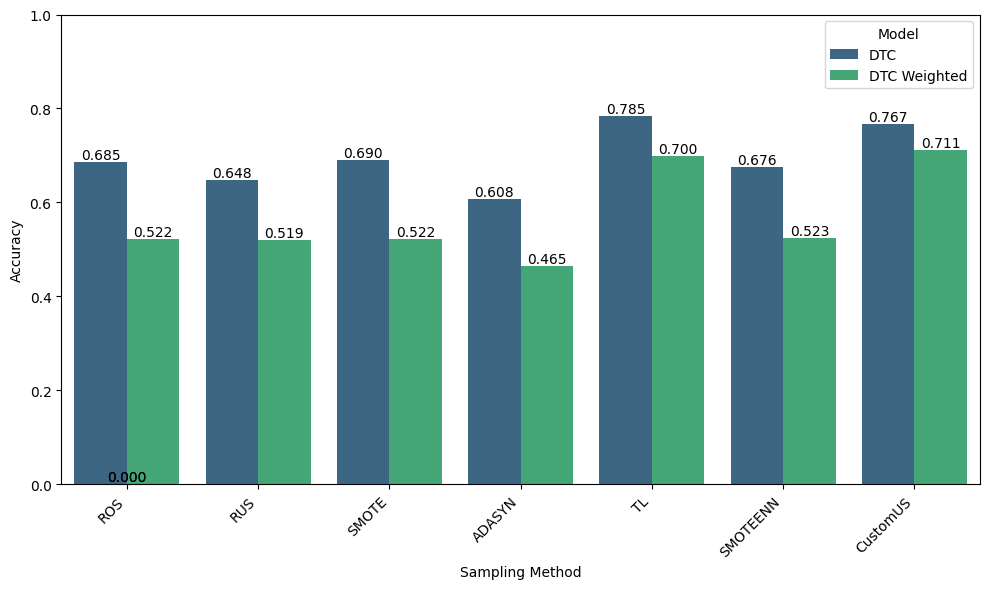

In [80]:
acc_DTC_list = []; acc_DTC_weighted_list = []

for preds in all_DTC_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_DTC_list.append(acc)
acc_DTC_list.append(accuracy_score(y_valid_df_upd_bal,all_DTC_rebalanced_preds[-1]))
acc_DTC_dict = {'Sampling Method':methods_used, 'Accuracy':acc_DTC_list}

for preds in all_DTC_weighted_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_DTC_weighted_list.append(acc)
acc_DTC_weighted_list.append(accuracy_score(y_valid_df_upd_bal,all_DTC_weighted_rebalanced_preds[-1]))
acc_DTC_weighted_dict = {'Sampling Method':methods_used, 'Accuracy':acc_DTC_weighted_list}

# Combine the data into a single DataFrame
acc_DTC_df = pd.DataFrame(acc_DTC_dict)
acc_DTC_df['Model'] = 'DTC'

acc_DTC_weighted_df = pd.DataFrame(acc_DTC_weighted_dict)
acc_DTC_weighted_df['Model'] = 'DTC Weighted'
combined_df = pd.concat([acc_DTC_df, acc_DTC_weighted_df], ignore_index=True)

# Plot the combined data

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='Accuracy', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the accuracy score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


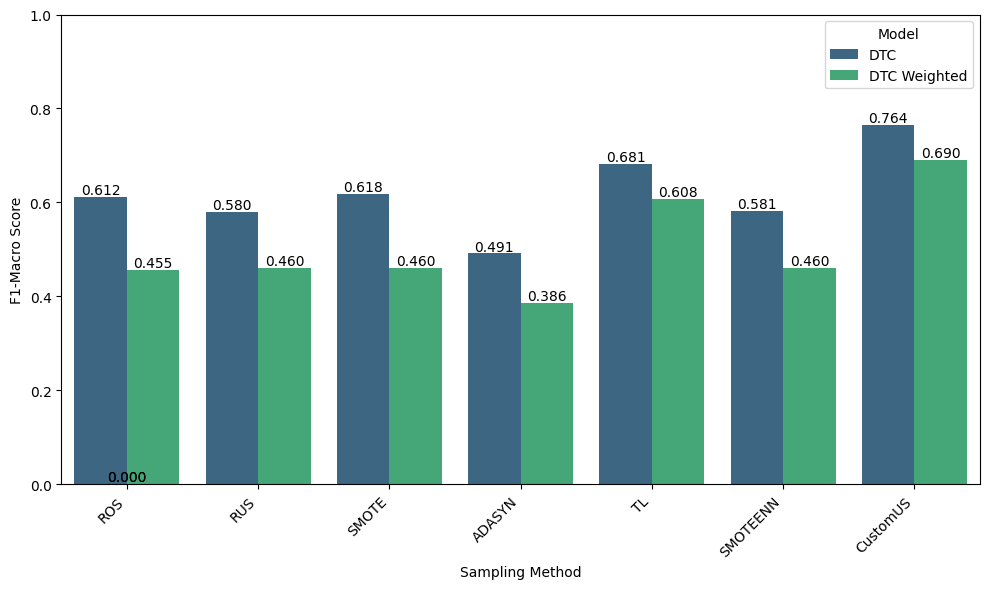

In [81]:
f1_DTC_list = []; f1_DTC_weighted_list = []

for preds in all_DTC_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_DTC_list.append(f1macro)
f1_DTC_list.append(f1_score(y_valid_df_upd_bal,all_DTC_rebalanced_preds[-1],average='macro'))
f1_DTC_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_DTC_list}

for preds in all_DTC_weighted_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_DTC_weighted_list.append(f1macro)
f1_DTC_weighted_list.append(f1_score(y_valid_df_upd_bal,all_DTC_weighted_rebalanced_preds[-1],average='macro'))
f1_DTC_weighted_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_DTC_weighted_list}

# Combine the data into a single DataFrame
f1_DTC_df = pd.DataFrame(f1_DTC_dict)
f1_DTC_df['Model'] = 'DTC'

f1_DTC_weighted_df = pd.DataFrame(f1_DTC_weighted_dict)
f1_DTC_weighted_df['Model'] = 'DTC Weighted'
combined_df = pd.concat([f1_DTC_df, f1_DTC_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


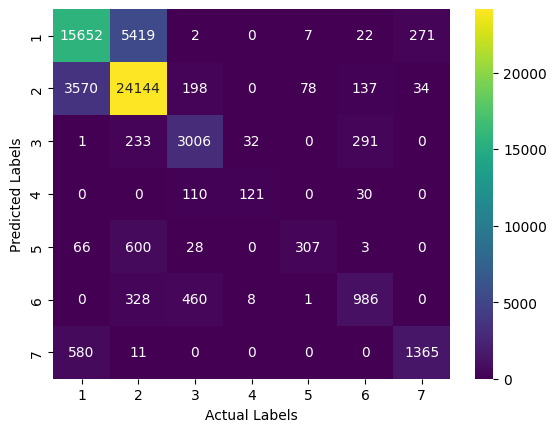

In [ ]:
conf_matrix1 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_DTC_rebalanced_preds[4])
sns.heatmap(conf_matrix1, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

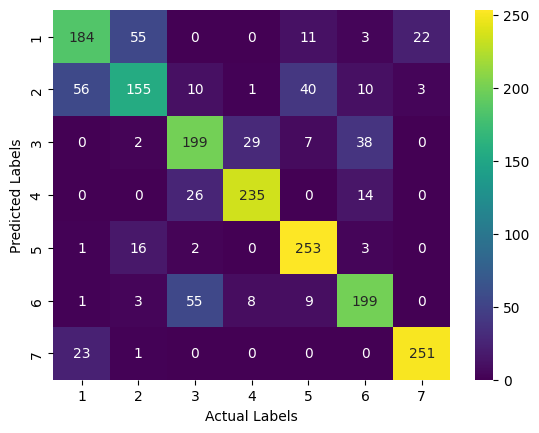

In [148]:
conf_matrix2 = confusion_matrix_7by7(y_valid_df_upd_bal, all_DTC_rebalanced_preds[-1])
sns.heatmap(conf_matrix2, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

In [97]:
print('Classifier: MLR  |  Training Set: Rebalanced')
ROS_preds_MLR = fit_predict_MLR(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal)
RUS_preds_MLR = fit_predict_MLR(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal)
SMOTE_preds_MLR = fit_predict_MLR(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal)
ADASYN_preds_MLR = fit_predict_MLR(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal)
TL_preds_MLR = fit_predict_MLR(TL_X_train, TL_y_train,X_valid_df_upd_imbal)
SMOTEENN_preds_MLR = fit_predict_MLR(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal)
customUS_preds_MLR = fit_predict_MLR(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal)
print('All fitting complete')

all_MLR_rebalanced_preds = [ROS_preds_MLR,RUS_preds_MLR,SMOTE_preds_MLR,
                            ADASYN_preds_MLR,TL_preds_MLR,SMOTEENN_preds_MLR,customUS_preds_MLR]

with open('MLR_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_MLR_rebalanced_preds, file)

Classifier: MLR  |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [158]:
all_MLR_rebalanced_preds[-1] = fit_predict_MLR(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal)

Fitting complete


In [40]:
print('Classifier: MLR weighted |  Training Set: Rebalanced')
ROS_preds_MLR_weighted = fit_predict_MLR(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal,class_weights)
RUS_preds_MLR_weighted = fit_predict_MLR(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal,class_weights)
SMOTE_preds_MLR_weighted = fit_predict_MLR(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal,class_weights)
ADASYN_preds_MLR_weighted = fit_predict_MLR(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal,class_weights)
TL_preds_MLR_weighted = fit_predict_MLR(TL_X_train, TL_y_train,X_valid_df_upd_imbal,class_weights)
SMOTEENN_preds_MLR_weighted = fit_predict_MLR(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal,class_weights)
customUS_preds_MLR_weighted = fit_predict_MLR(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal, class_weights)
print('All fitting complete')

all_MLR_weighted_rebalanced_preds = [ROS_preds_MLR_weighted,RUS_preds_MLR_weighted,SMOTE_preds_MLR_weighted,
                                     ADASYN_preds_MLR_weighted,TL_preds_MLR_weighted,SMOTEENN_preds_MLR_weighted,
                                     customUS_preds_MLR_weighted]

with open('MLR_weighted_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_MLR_weighted_rebalanced_preds, file)

Classifier: MLR weighted |  Training Set: Rebalanced


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting complete
Fitting complete
All fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [98]:
print('Classifier: MLR weighted |  Training Set: Imbalanced')
preds_MLR_weighted_imbal = fit_predict_MLR(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal,class_weights)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_MLR_weighted_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_MLR_weighted_imbal)}")

with open('MLR_weighted_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_MLR_weighted_imbal, file)

Classifier: MLR weighted |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.34567861463183147
Accuracy: 0.45758248567150306


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [99]:
print('Classifier: MLR  |  Training Set: Imbalanced')
preds_MLR_imbal = fit_predict_MLR(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_MLR_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_MLR_imbal)}")

with open('MLR_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_MLR_imbal, file)

Classifier: MLR  |  Training Set: Imbalanced


Fitting complete
F1-macro: 0.32015412475419996
Accuracy: 0.6762706321750056


In [37]:
with open('MLR_rebalanced_preds.pkl', 'rb') as file1:
    all_MLR_rebalanced_preds = pickle.load(file1)

with open('MLR_weighted_rebalanced_preds.pkl', 'rb') as file2:
    all_MLR_weighted_rebalanced_preds = pickle.load(file2)
    
with open('MLR_weighted_imbal_preds.pkl', 'rb') as file3:
    preds_MLR_weighted_imbal = pickle.load(file3)

with open('MLR_imbal_preds.pkl', 'rb') as file4:
    preds_MLR_imbal = pickle.load(file4)

In [39]:
methods_used

['ROS', 'RUS', 'SMOTE', 'ADASYN', 'TL', 'SMOTEENN', 'CustomUS']

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


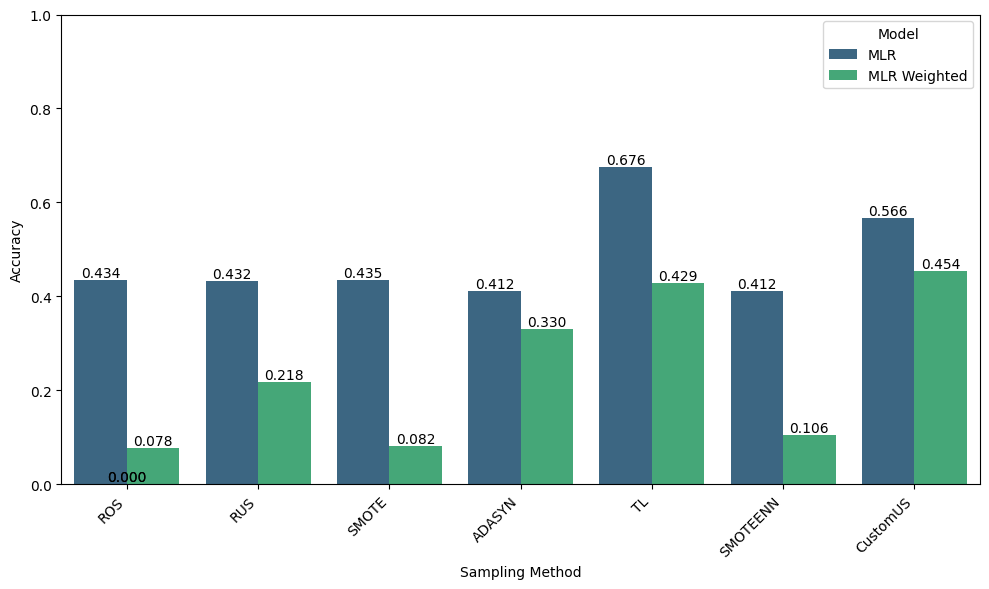

In [164]:
acc_MLR_list = []; acc_MLR_weighted_list = []

for preds in all_MLR_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_MLR_list.append(acc)
acc_MLR_list.append(accuracy_score(y_valid_df_upd_bal,all_MLR_rebalanced_preds[-1]))
acc_MLR_dict = {'Sampling Method':methods_used, 'Accuracy':acc_MLR_list}

for preds in all_MLR_weighted_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_MLR_weighted_list.append(acc)
acc_MLR_weighted_list.append(accuracy_score(y_valid_df_upd_bal,all_MLR_weighted_rebalanced_preds[-1]))
acc_MLR_weighted_dict = {'Sampling Method':methods_used, 'Accuracy':acc_MLR_weighted_list}

# Combine the data into a single DataFrame
acc_MLR_df = pd.DataFrame(acc_MLR_dict)
acc_MLR_df['Model'] = 'MLR'

acc_MLR_weighted_df = pd.DataFrame(acc_MLR_weighted_dict)
acc_MLR_weighted_df['Model'] = 'MLR Weighted'
combined_df = pd.concat([acc_MLR_df, acc_MLR_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='Accuracy', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the accuracy score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


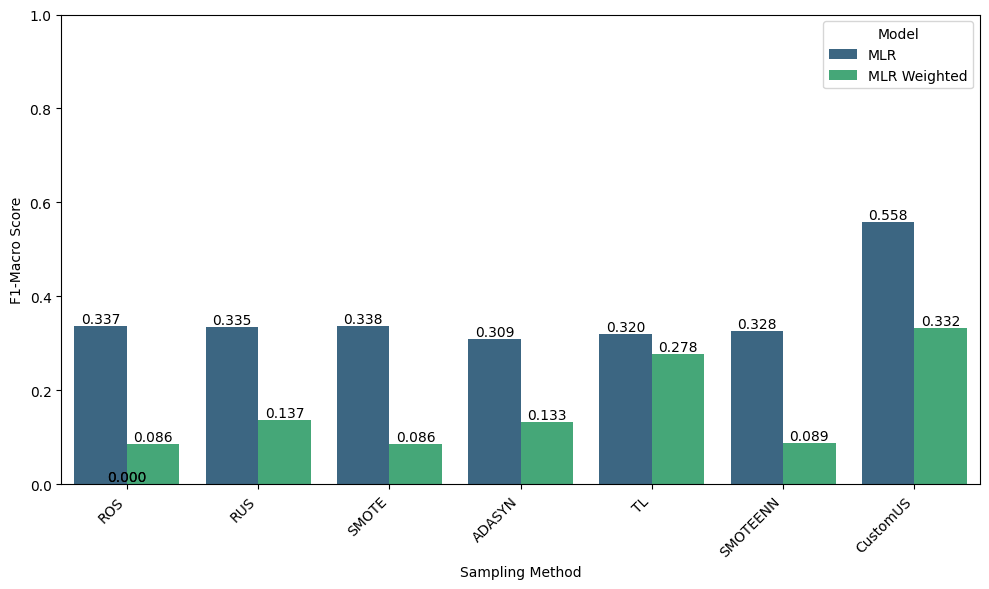

In [165]:
f1_MLR_list = []; f1_MLR_weighted_list = []

for preds in all_MLR_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_MLR_list.append(f1macro)
f1_MLR_list.append(f1_score(y_valid_df_upd_bal,all_MLR_rebalanced_preds[-1],average='macro'))
f1_MLR_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_MLR_list}

for preds in all_MLR_weighted_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_MLR_weighted_list.append(f1macro)
f1_MLR_weighted_list.append(f1_score(y_valid_df_upd_bal,all_MLR_weighted_rebalanced_preds[-1],average='macro'))
f1_MLR_weighted_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_MLR_weighted_list}

# Combine the data into a single DataFrame
f1_MLR_df = pd.DataFrame(f1_MLR_dict)
f1_MLR_df['Model'] = 'MLR'

f1_MLR_weighted_df = pd.DataFrame(f1_MLR_weighted_dict)
f1_MLR_weighted_df['Model'] = 'MLR Weighted'
combined_df = pd.concat([f1_MLR_df, f1_MLR_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


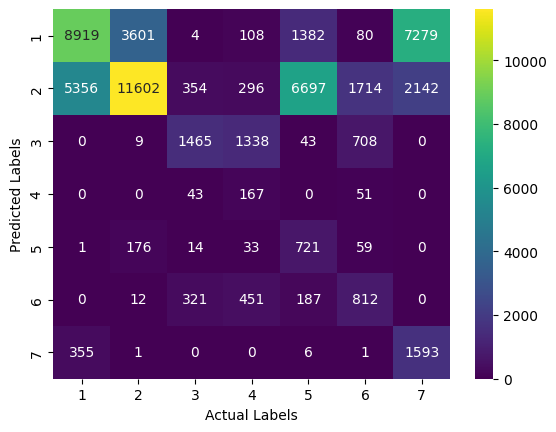

In [73]:
conf_matrix3 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_MLR_rebalanced_preds[2])
sns.heatmap(conf_matrix3, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

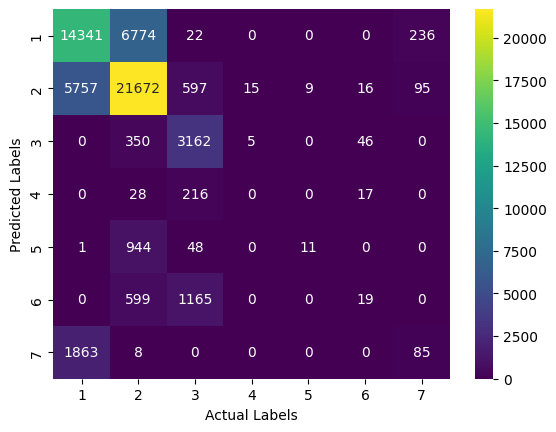

In [74]:
conf_matrix4 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_MLR_rebalanced_preds[4])
sns.heatmap(conf_matrix4, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

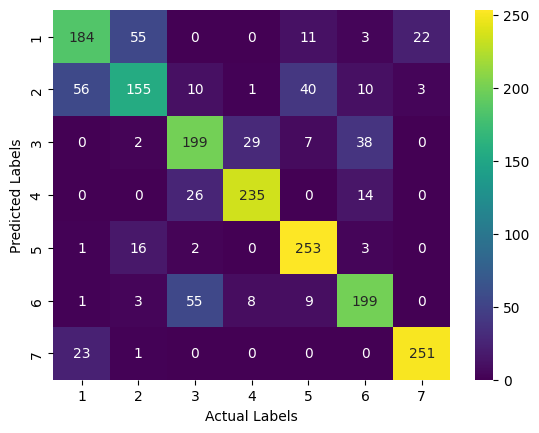

In [75]:
conf_matrix5 = confusion_matrix_7by7(y_valid_df_upd_bal, all_MLR_rebalanced_preds[-1])
sns.heatmap(conf_matrix5, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

In [45]:
print('Classifier: RFC  |  Training Set: Rebalanced')
ROS_preds_RFC = fit_predict_RFC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal)
RUS_preds_RFC = fit_predict_RFC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal)
SMOTE_preds_RFC = fit_predict_RFC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal)
ADASYN_preds_RFC = fit_predict_RFC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal)
TL_preds_RFC = fit_predict_RFC(TL_X_train, TL_y_train,X_valid_df_upd_imbal)
SMOTEENN_preds_RFC = fit_predict_RFC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal)
customUS_preds_RFC = fit_predict_RFC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal)
print('All fitting complete')

all_RFC_rebalanced_preds = [ROS_preds_RFC,RUS_preds_RFC,SMOTE_preds_RFC,
                            ADASYN_preds_RFC,TL_preds_RFC,SMOTEENN_preds_RFC,customUS_preds_RFC]

with open('RFC_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_RFC_rebalanced_preds, file)

Classifier: RFC  |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [46]:
print('Classifier: RFC weighted |  Training Set: Rebalanced')
ROS_preds_RFC_weighted = fit_predict_RFC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal,class_weights)
RUS_preds_RFC_weighted = fit_predict_RFC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal,class_weights)
SMOTE_preds_RFC_weighted = fit_predict_RFC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal,class_weights)
ADASYN_preds_RFC_weighted = fit_predict_RFC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal,class_weights)
TL_preds_RFC_weighted = fit_predict_RFC(TL_X_train, TL_y_train,X_valid_df_upd_imbal,class_weights)
SMOTEENN_preds_RFC_weighted = fit_predict_RFC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal,class_weights)
customUS_preds_RFC_weighted = fit_predict_RFC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal,class_weights)
print('All fitting complete')

all_RFC_weighted_rebalanced_preds = [ROS_preds_RFC_weighted,RUS_preds_RFC_weighted,SMOTE_preds_RFC_weighted,
                                     ADASYN_preds_RFC_weighted,TL_preds_RFC_weighted,SMOTEENN_preds_RFC_weighted,
                                     customUS_preds_RFC_weighted]

with open('RFC_weighted_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_RFC_weighted_rebalanced_preds, file)

Classifier: RFC weighted |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [47]:
print('Classifier: RFC weighted |  Training Set: Imbalanced')
preds_RFC_weighted_imbal = fit_predict_RFC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal,class_weights)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_RFC_weighted_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_RFC_weighted_imbal)}")

with open('RFC_weighted_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_RFC_weighted_imbal, file)

Classifier: RFC weighted |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.6580097282714947
Accuracy: 0.7310889657665101


In [48]:
print('Classifier: RFC  |  Training Set: Imbalanced')
preds_RFC_imbal = fit_predict_RFC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_RFC_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_RFC_imbal)}")

with open('RFC_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_RFC_imbal, file)

Classifier: RFC  |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.7175630683290869
Accuracy: 0.7997280597580076


In [ ]:
with open('RFC_rebalanced_preds.pkl', 'rb') as file1:
    all_RFC_rebalanced_preds = pickle.load(file1)

with open('RFC_weighted_rebalanced_preds.pkl', 'rb') as file2:
    all_RFC_weighted_rebalanced_preds = pickle.load(file2)
    
with open('RFC_weighted_imbal_preds.pkl', 'rb') as file3:
    preds_RFC_weighted_imbal = pickle.load(file3)

with open('RFC_imbal_preds.pkl', 'rb') as file4:
    preds_RFC_imbal = pickle.load(file4)

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


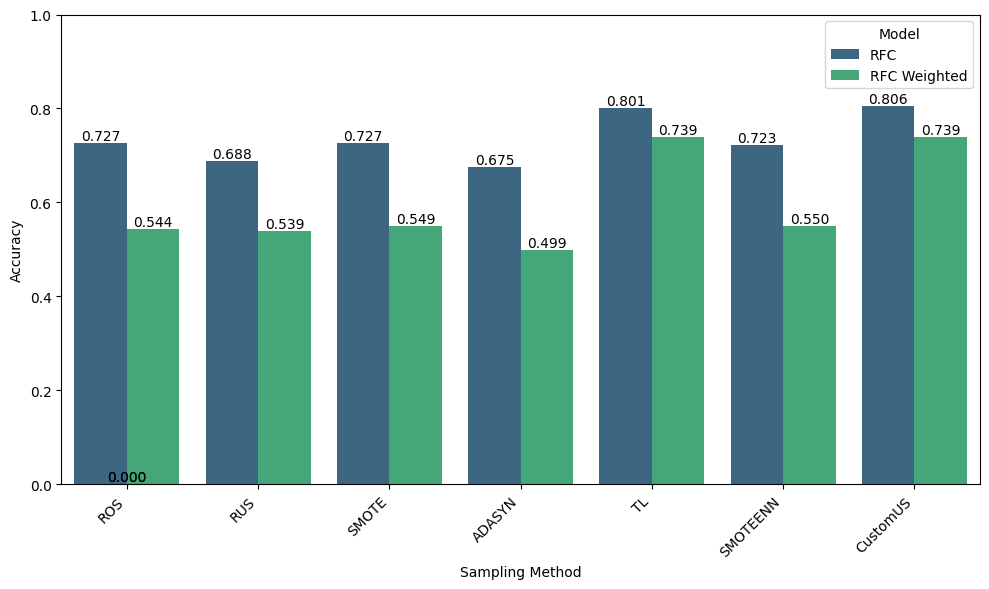

In [70]:
acc_RFC_list = []; acc_RFC_weighted_list = []

for preds in all_RFC_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_RFC_list.append(acc)
acc_RFC_list.append(accuracy_score(y_valid_df_upd_bal,all_RFC_rebalanced_preds[-1]))
acc_RFC_dict = {'Sampling Method':methods_used, 'Accuracy':acc_RFC_list}

for preds in all_RFC_weighted_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_RFC_weighted_list.append(acc)
acc_RFC_weighted_list.append(accuracy_score(y_valid_df_upd_bal,all_RFC_weighted_rebalanced_preds[-1]))
acc_RFC_weighted_dict = {'Sampling Method':methods_used, 'Accuracy':acc_RFC_weighted_list}

# Combine the data into a single DataFrame
acc_RFC_df = pd.DataFrame(acc_RFC_dict)
acc_RFC_df['Model'] = 'RFC'

acc_RFC_weighted_df = pd.DataFrame(acc_RFC_weighted_dict)
acc_RFC_weighted_df['Model'] = 'RFC Weighted'
combined_df = pd.concat([acc_RFC_df, acc_RFC_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='Accuracy', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the accuracy score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


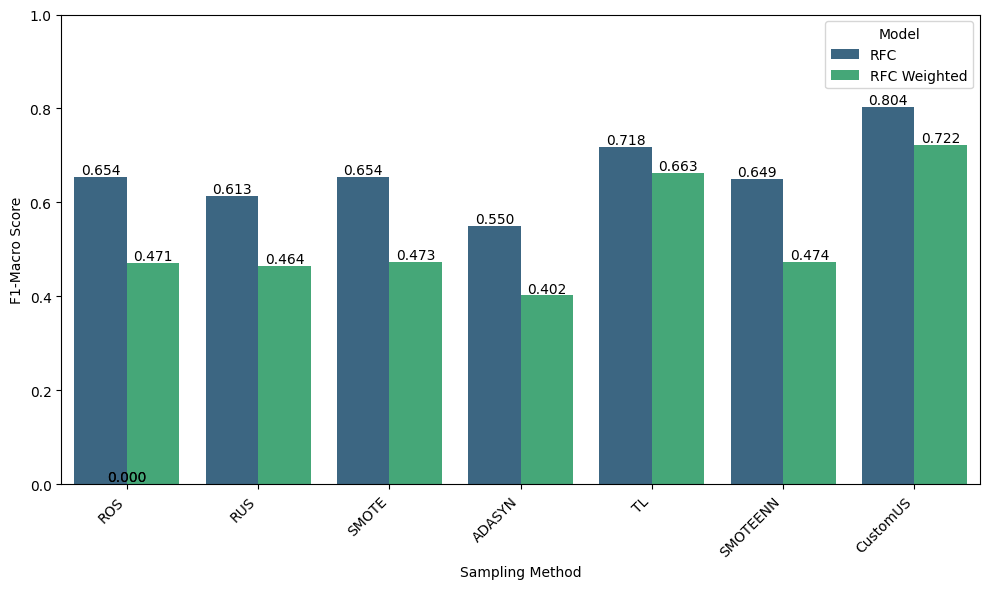

In [85]:
f1_RFC_list = []; f1_RFC_weighted_list = []

for preds in all_RFC_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_RFC_list.append(f1macro)
f1_RFC_list.append(f1_score(y_valid_df_upd_bal,all_RFC_rebalanced_preds[-1],average='macro'))
f1_RFC_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_RFC_list}

for preds in all_RFC_weighted_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_RFC_weighted_list.append(f1macro)
f1_RFC_weighted_list.append(f1_score(y_valid_df_upd_bal,all_RFC_weighted_rebalanced_preds[-1],average='macro'))
f1_RFC_weighted_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_RFC_weighted_list}

# Combine the data into a single DataFrame
f1_RFC_df = pd.DataFrame(f1_RFC_dict)
f1_RFC_df['Model'] = 'RFC'

f1_RFC_weighted_df = pd.DataFrame(f1_RFC_weighted_dict)
f1_RFC_weighted_df['Model'] = 'RFC Weighted'
combined_df = pd.concat([f1_RFC_df, f1_RFC_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


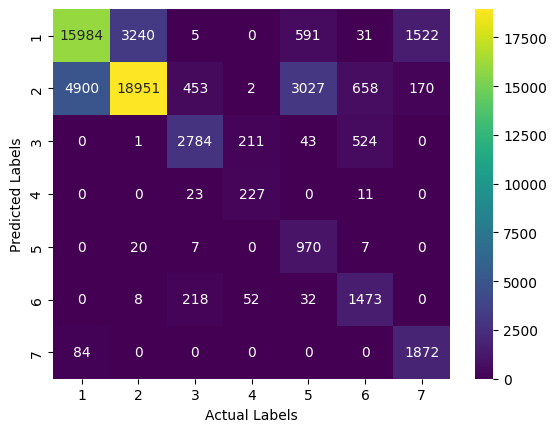

In [80]:
conf_matrix6 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_RFC_rebalanced_preds[2])
sns.heatmap(conf_matrix6, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

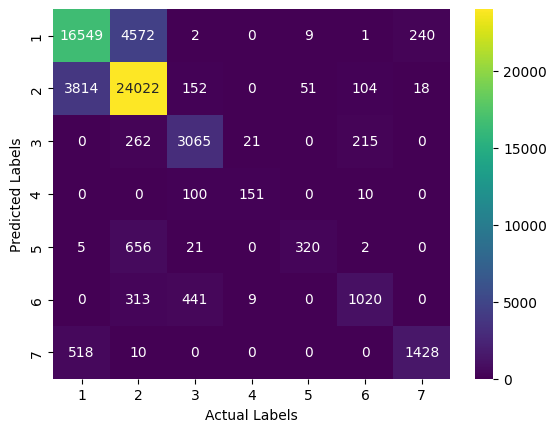

In [81]:
conf_matrix7 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_RFC_rebalanced_preds[4])
sns.heatmap(conf_matrix7, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

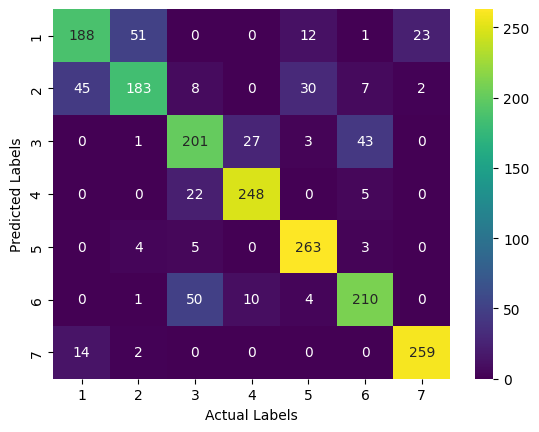

In [82]:
conf_matrix8 = confusion_matrix_7by7(y_valid_df_upd_bal, all_RFC_rebalanced_preds[-1])
sns.heatmap(conf_matrix8, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

In [99]:
print('Classifier: XGBC  |  Training Set: Rebalanced')
ROS_preds_XGBC = fit_predict_XGBC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal)
RUS_preds_XGBC = fit_predict_XGBC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal)
SMOTE_preds_XGBC = fit_predict_XGBC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal)
ADASYN_preds_XGBC = fit_predict_XGBC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal)
TL_preds_XGBC = fit_predict_XGBC(TL_X_train, TL_y_train,X_valid_df_upd_imbal)
SMOTEENN_preds_XGBC = fit_predict_XGBC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal)
customUS_preds_XGBC = fit_predict_XGBC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal)
print('All fitting complete')

all_XGBC_rebalanced_preds = [ROS_preds_XGBC,RUS_preds_XGBC,SMOTE_preds_XGBC,
                            ADASYN_preds_XGBC,TL_preds_XGBC,SMOTEENN_preds_XGBC,customUS_preds_XGBC]

with open('XGBC_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_XGBC_rebalanced_preds, file)

Classifier: XGBC  |  Training Set: Rebalanced
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
Fitting complete
All fitting complete


In [100]:
print('Classifier: XGBC weighted |  Training Set: Rebalanced')
ROS_preds_XGBC_weighted = fit_predict_XGBC(ROS_X_train,ROS_y_train,X_valid_df_upd_imbal,'balanced')
RUS_preds_XGBC_weighted = fit_predict_XGBC(RUS_X_train, RUS_y_train,X_valid_df_upd_imbal,'balanced')
SMOTE_preds_XGBC_weighted = fit_predict_XGBC(SMOTE_X_train, SMOTE_y_train,X_valid_df_upd_imbal,'balanced')
ADASYN_preds_XGBC_weighted = fit_predict_XGBC(ADASYN_X_train, ADASYN_y_train,X_valid_df_upd_imbal,'balanced')
TL_preds_XGBC_weighted = fit_predict_XGBC(TL_X_train, TL_y_train,X_valid_df_upd_imbal,'balanced')
SMOTEENN_preds_XGBC_weighted = fit_predict_XGBC(SMOTEENN_X_train, SMOTEENN_y_train,X_valid_df_upd_imbal,'balanced')
customUS_preds_XGBC_weighted = fit_predict_XGBC(X_train_df_upd_bal, y_train_df_upd_bal,X_valid_df_upd_bal,'balanced')
print('All fitting complete')

all_XGBC_weighted_rebalanced_preds = [ROS_preds_XGBC_weighted,RUS_preds_XGBC_weighted,SMOTE_preds_XGBC_weighted,
                                     ADASYN_preds_XGBC_weighted,TL_preds_XGBC_weighted,SMOTEENN_preds_XGBC_weighted,
                                     customUS_preds_XGBC_weighted]

with open('XGBC_weighted_rebalanced_preds.pkl', 'wb') as file:
    pickle.dump(all_XGBC_weighted_rebalanced_preds, file)

Classifier: XGBC weighted |  Training Set: Rebalanced


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:30:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete
All fitting complete


In [104]:
print('Classifier: XGBC weighted |  Training Set: Imbalanced')
preds_XGBC_weighted_imbal = fit_predict_XGBC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal,'balanced')
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_XGBC_weighted_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_XGBC_weighted_imbal)}")

with open('XGBC_weighted_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_XGBC_weighted_imbal, file)

Classifier: XGBC weighted |  Training Set: Imbalanced


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting complete
F1-macro: 0.8729779595308506
Accuracy: 0.9291578458202097


In [105]:
print('Classifier: XGBC  |  Training Set: Imbalanced')
preds_XGBC_imbal = fit_predict_XGBC(X_train_df_upd_imbal,y_train_df_upd_imbal,X_valid_df_upd_imbal)
print(f"F1-macro: {f1_score(y_valid_df_upd_imbal,preds_XGBC_imbal,average='macro')}")
print(f"Accuracy: {accuracy_score(y_valid_df_upd_imbal,preds_XGBC_imbal)}")

with open('XGBC_imbal_preds.pkl', 'wb') as file:
    pickle.dump(preds_XGBC_imbal, file)

Classifier: XGBC  |  Training Set: Imbalanced
Fitting complete
F1-macro: 0.8729779595308506
Accuracy: 0.9291578458202097


/var/folders/8v/b2lj27n926xdzf5cl1ym3cpm0000gn/T/ipykernel_72525/2981643779.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sampling Method', y='Accuracy', data=acc_XGBC_df, palette='viridis')
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_g

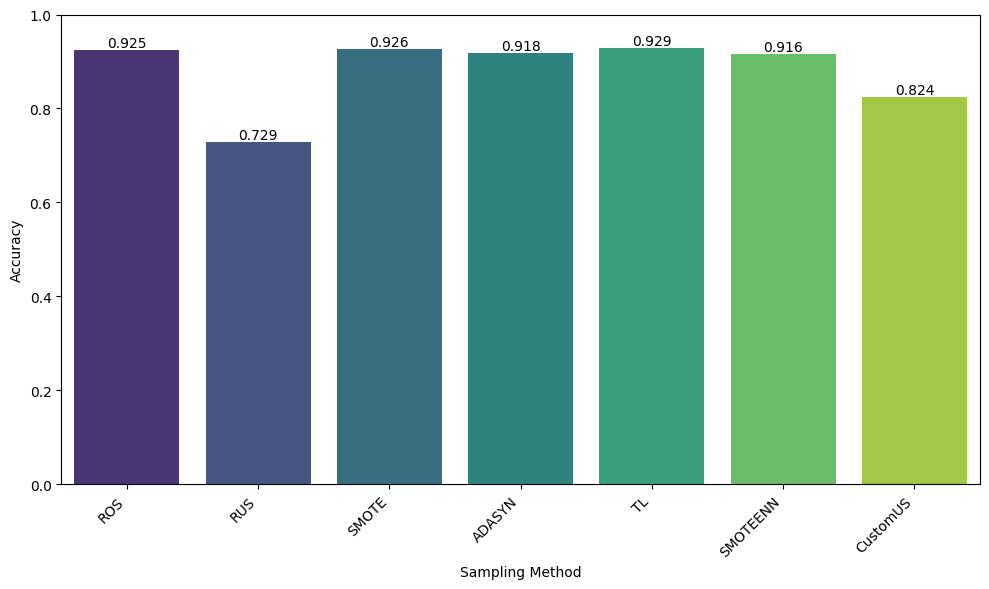

In [108]:
acc_XGBC_list = []; acc_XGBC_weighted_list = []

for preds in all_XGBC_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_XGBC_list.append(acc)
acc_XGBC_list.append(accuracy_score(y_valid_df_upd_bal,all_XGBC_rebalanced_preds[-1]))
acc_XGBC_dict = {'Sampling Method':methods_used, 'Accuracy':acc_XGBC_list}

for preds in all_XGBC_weighted_rebalanced_preds[:-1]:
    acc = accuracy_score(y_valid_df_upd_imbal,preds)
    acc_XGBC_weighted_list.append(acc)
acc_XGBC_weighted_list.append(accuracy_score(y_valid_df_upd_bal,all_XGBC_weighted_rebalanced_preds[-1]))
acc_XGBC_weighted_dict = {'Sampling Method':methods_used, 'Accuracy':acc_XGBC_weighted_list}

# Combine the data into a single DataFrame
acc_XGBC_df = pd.DataFrame(acc_XGBC_dict)
acc_XGBC_df['Model'] = 'XGBC'

acc_XGBC_weighted_df = pd.DataFrame(acc_XGBC_weighted_dict)
acc_XGBC_weighted_df['Model'] = 'RFC Weighted'
combined_df = pd.concat([acc_XGBC_df, acc_XGBC_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='Accuracy', data=acc_XGBC_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

/var/folders/8v/b2lj27n926xdzf5cl1ym3cpm0000gn/T/ipykernel_72525/3723782948.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sampling Method', y='F1-Macro', data=f1_XGBC_df, palette='viridis')
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

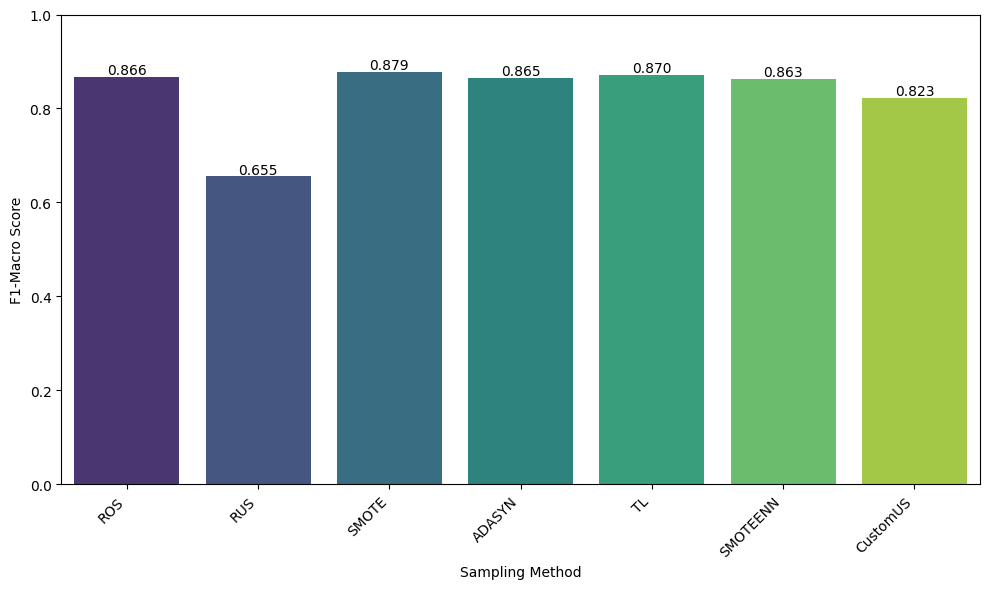

In [109]:
f1_XGBC_list = []; f1_XGBC_weighted_list = []

for preds in all_XGBC_rebalanced_preds[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_XGBC_list.append(f1macro)
f1_XGBC_list.append(f1_score(y_valid_df_upd_bal,all_XGBC_rebalanced_preds[-1],average='macro'))
f1_XGBC_dict = {'Sampling Method':methods_used, 'F1-Macro':f1_XGBC_list}

# Combine the data into a single DataFrame
f1_XGBC_df = pd.DataFrame(f1_XGBC_dict)
f1_XGBC_df['Model'] = 'XGBC'

# Plot the combined data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', data=f1_XGBC_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


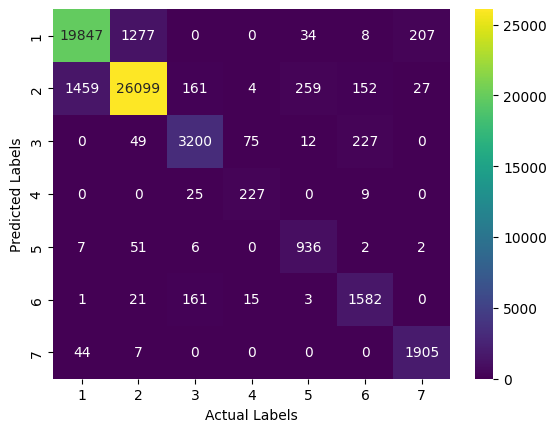

In [83]:
conf_matrix9 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_XGBC_rebalanced_preds[2])
sns.heatmap(conf_matrix9, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

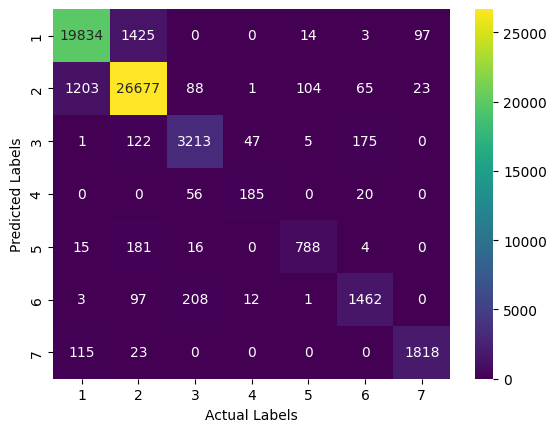

In [84]:
conf_matrix10 = confusion_matrix_7by7(y_valid_df_upd_imbal, all_XGBC_rebalanced_preds[4])
sns.heatmap(conf_matrix10, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

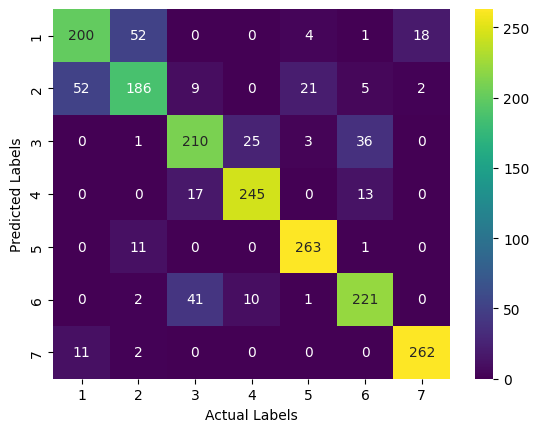

In [85]:
conf_matrix11 = confusion_matrix_7by7(y_valid_df_upd_bal, all_XGBC_rebalanced_preds[-1])
sns.heatmap(conf_matrix11, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

### 7. Final Testing

In [173]:
final_model = xgb.XGBClassifier(tree_method='hist', multi_strategy = 'multi_output_tree',
                                gamma = 0, learning_rate = 0.8, max_depth = 12, 
                                alpha = 0.75, reg_lambda = 0.75)
final_model.fit(SMOTE_X_train, SMOTE_y_train-1)
y_preds = final_model.predict(X_test_df_upd_imbal)

Accuracy score: 0.9233072871846064
F1-macro score: 0.8665829739764518


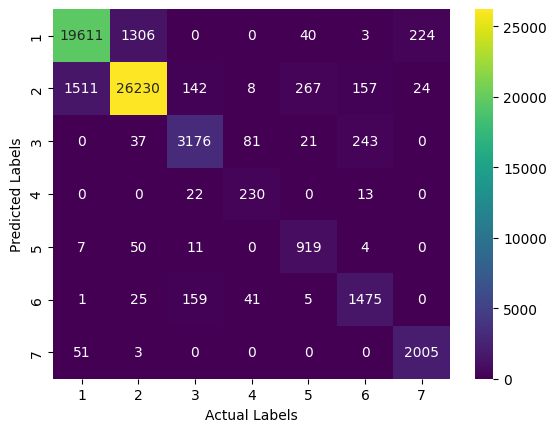

In [174]:
print(f"Accuracy score: {accuracy_score(y_test_df_upd_imbal,y_preds+1)}")
print(f"F1-macro score: {f1_score(y_test_df_upd_imbal,y_preds+1,average='macro')}")
conf_matrix = confusion_matrix_7by7(y_test_df_upd_imbal,y_preds+1)

sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='viridis') # fmt='d' ensures integers are displayed
plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')
plt.xticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8))
plt.yticks(ticks=np.arange(7) + 0.5, labels=np.arange(1, 8)) 
plt.show()

In [43]:
with open('RFC_rebalanced_preds.pkl', 'rb') as file1:
    all_RFC_rebalanced_preds = pickle.load(file1)

with open('RFC_weighted_rebalanced_preds.pkl', 'rb') as file2:
    all_RFC_weighted_rebalanced_preds = pickle.load(file2)

with open('XGBC_rebalanced_preds.pkl', 'rb') as file3:
    all_XGBC_rebalanced_preds = pickle.load(file3)

with open('XGBC_weighted_rebalanced_preds.pkl', 'rb') as file4:
    all_XGBC_weighted_rebalanced_preds = pickle.load(file4) 

In [44]:
MLR_chosen = []; RFC_chosen = []; XGBC_chosen = []
for i in [2,4,6]:
    MLR_chosen.append(all_MLR_rebalanced_preds[i])
    RFC_chosen.append(all_RFC_rebalanced_preds[i])
    XGBC_chosen.append(all_XGBC_rebalanced_preds[i])

In [45]:
MLR_weight_chosen = []; RFC_weight_chosen = []; XGBC_weight_chosen = []
for i in [2,4,6]:
    MLR_weight_chosen.append(all_MLR_weighted_rebalanced_preds[i])
    RFC_weight_chosen.append(all_RFC_weighted_rebalanced_preds[i])
    XGBC_weight_chosen.append(all_XGBC_weighted_rebalanced_preds[i])

/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


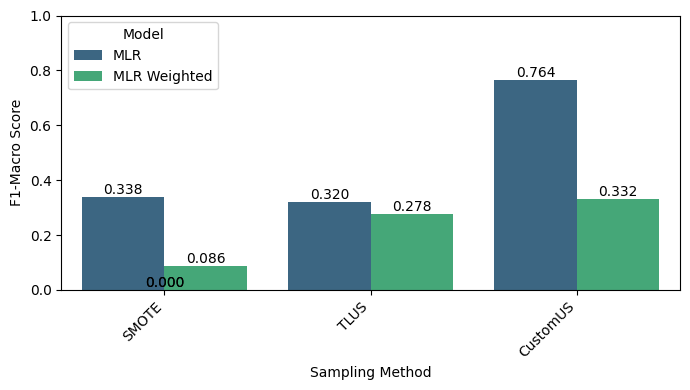

In [52]:
f1_list = []; f1_weighted_list = []

for preds in MLR_chosen[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_list.append(f1macro)
f1_list.append(f1_score(y_valid_df_upd_bal,MLR_chosen[-1],average='macro'))
f1_dict = {'Sampling Method':['SMOTE','TLUS','CustomUS'], 'F1-Macro':f1_list}

for preds in MLR_weight_chosen[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_weighted_list.append(f1macro)
f1_weighted_list.append(f1_score(y_valid_df_upd_bal,MLR_weight_chosen[-1],average='macro'))
f1_weighted_dict = {'Sampling Method':['SMOTE','TLUS','CustomUS'], 'F1-Macro':f1_weighted_list}

# Combine the data into a single DataFrame
f1_df = pd.DataFrame(f1_dict)
f1_df['Model'] = 'MLR'

f1_weighted_df = pd.DataFrame(f1_weighted_dict)
f1_weighted_df['Model'] = 'MLR Weighted'
combined_df = pd.concat([f1_df, f1_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


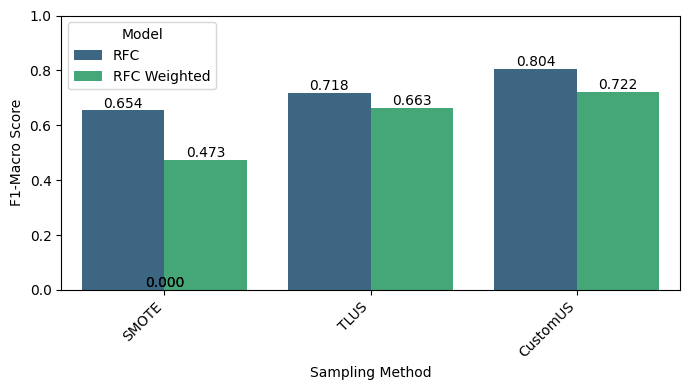

In [57]:
f1_list = []; f1_weighted_list = []

for preds in RFC_chosen[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_list.append(f1macro)
f1_list.append(f1_score(y_valid_df_upd_bal,RFC_chosen[-1],average='macro'))
f1_dict = {'Sampling Method':['SMOTE','TLUS','CustomUS'], 'F1-Macro':f1_list}

for preds in RFC_weight_chosen[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_weighted_list.append(f1macro)
f1_weighted_list.append(f1_score(y_valid_df_upd_bal,RFC_weight_chosen[-1],average='macro'))
f1_weighted_dict = {'Sampling Method':['SMOTE','TLUS','CustomUS'], 'F1-Macro':f1_weighted_list}

# Combine the data into a single DataFrame
f1_df = pd.DataFrame(f1_dict)
f1_df['Model'] = 'RFC'

f1_weighted_df = pd.DataFrame(f1_weighted_dict)
f1_weighted_df['Model'] = 'RFC Weighted'
combined_df = pd.concat([f1_df, f1_weighted_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', hue='Model', data=combined_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()


/var/folders/8v/b2lj27n926xdzf5cl1ym3cpm0000gn/T/ipykernel_71212/565901870.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sampling Method', y='F1-Macro', data=f1_XGBC_df, palette='viridis')
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Applications/anaconda3/envs/fyp/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

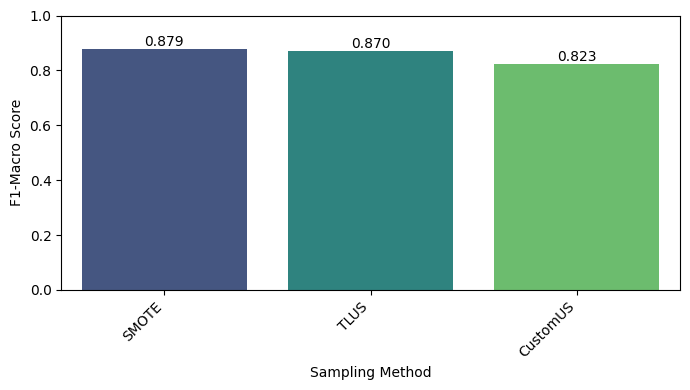

In [60]:
f1_XGBC_list = []; f1_XGBC_weighted_list = []

for preds in XGBC_chosen[:-1]:
    f1macro = f1_score(y_valid_df_upd_imbal,preds,average='macro')
    f1_XGBC_list.append(f1macro)
f1_XGBC_list.append(f1_score(y_valid_df_upd_bal,XGBC_chosen[-1],average='macro'))
f1_XGBC_dict = {'Sampling Method':['SMOTE','TLUS','CustomUS'], 'F1-Macro':f1_XGBC_list}

# Combine the data into a single DataFrame
f1_XGBC_df = pd.DataFrame(f1_XGBC_dict)
f1_XGBC_df['Model'] = 'XGBC'

# Plot the combined data
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Sampling Method', y='F1-Macro', data=f1_XGBC_df, palette='viridis')
plt.xlabel('Sampling Method')
plt.ylabel('F1-Macro Score')
plt.ylim((0, 1))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the f1-macro score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()
